In [1]:
import sys
#!{sys.executable} -m pip install pymongo
#!{sys.executable} -m pip install pyyaml
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install isoweek

#!{sys.executable} -m pip install rpy2

In [2]:

import os
print(os.getcwd())
# Get Mongo database
from yaml import load
from pymongo import MongoClient
from getsecret import getsecret

client = MongoClient(getsecret("EXT_URI"))
db = client[getsecret("MOBILE_NAME")]
ext_client = MongoClient(getsecret("EXT_URI"))

ext_db = ext_client[getsecret("DB_NAME")]
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))


### CONSTANTS ###
INTENSITY = "intensity"
TOTAL_TIME = "total_time"
ANDROID = "android"
HASH = "email_hash"
INSTALL = "install_id"
GOALS = "goals"
FREQ_GOALS = "freq_goals"
INFREQ_GOALS = "infreq_goals"
OTHER_TIME = "other_time"
FREQ_TIME ="freq_time"
GOAL_TIME = "goal_time"
TARGET_TIME = "target_time"
BROWSER = "browser"
BROWSER_DOMAIN = "browser_domain"
GOAL_TIMES = "goal_frequency_days"
FREQ_GOALS = "freq_goals"
INFREQ_GOALS = "infreq_goals"
BROWSER = "browser"
FREQUENCY = "frequency"
TIME = "time"
GOAL = "goal"
SPEND_LESS_TIME_LENGTH = len("custom/spend_less_time_")
AVG_FREQ_TIME = "avg_freq_time"
AVG_INFREQ_TIME = "avg_infreq_time"
AVG_GOAL_TIME = "avg_goal_time"
UNPRODUCTIVE_TIME = "unproductive_time"
PRODUCTIVE_TIME = "productive_time"
INFREQ_TIME = "infreq_time"
NUM_FREQ_GOALS = "num_freq_goals"
NUM_INFREQ_GOALS = "num_infreq_goals"
import time


### FUNCTIONS ###
# Get freq stats
# week -> goal -> freq
# Top-level-domain-names that are not pertinent to the application.
TLDs = ['aaa', 'abb', 'abc', 'ac', 'aco', 'ad', 'ads', 'ae', 'aeg', 'af', 'afl', 'ag', 'ai', 'aig', 'al', 'am', 'anz', 'ao', 'aol', 'app', 'aq', 'ar', 'art', 'as', 'at', 'au', 'aw', 'aws', 'ax', 'axa', 'az', 'ba', 'bar', 'bb', 'bbc', 'bbt', 'bcg', 'bcn', 'bd', 'be', 'bet', 'bf', 'bg', 'bh', 'bi', 'bid', 'bio', 'biz', 'bj', 'bm', 'bms', 'bmw', 'bn', 'bnl', 'bo', 'bom', 'boo', 'bot', 'box', 'br', 'bs', 'bt', 'buy', 'bv', 'bw', 'by', 'bz', 'bzh', 'ca', 'cab', 'cal', 'cam', 'car', 'cat', 'cba', 'cbn', 'cbs', 'cc', 'cd', 'ceb', 'ceo', 'cf', 'cfa', 'cfd', 'cg', 'ch', 'ci', 'ck', 'cl', 'cm', 'cn', 'co', 'com', 'cr', 'crs', 'csc', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'dad', 'day', 'dds', 'de', 'dev', 'dhl', 'diy', 'dj', 'dk', 'dm', 'dnp', 'do', 'dog', 'dot', 'dtv', 'dvr', 'dz', 'eat', 'ec', 'eco', 'edu', 'ee', 'eg', 'er', 'es', 'esq', 'et', 'eu', 'eus', 'fan', 'fi', 'fit', 'fj', 'fk', 'fly', 'fm', 'fo', 'foo', 'fox', 'fr', 'frl', 'ftr', 'fun', 'fyi', 'ga', 'gal', 'gap', 'gb', 'gd', 'gdn', 'ge', 'gea', 'gf', 'gg', 'gh', 'gi', 'gl', 'gle', 'gm', 'gmo', 'gmx', 'gn', 'goo', 'gop', 'got', 'gov', 'gp', 'gq', 'gr', 'gs', 'gt', 'gu', 'gw', 'gy', 'hbo', 'hiv', 'hk', 'hkt', 'hm', 'hn', 'hot', 'how', 'hr', 'ht', 'hu', 'ibm', 'ice', 'icu', 'id', 'ie', 'ifm', 'il', 'im', 'in', 'inc', 'ing', 'ink', 'int', 'io', 'iq', 'ir', 'is', 'ist', 'it', 'itv', 'jcb', 'jcp', 'je', 'jio', 'jlc', 'jll', 'jm', 'jmp', 'jnj', 'jo', 'jot', 'joy', 'jp', 'ke', 'kfh', 'kg', 'kh', 'ki', 'kia', 'kim', 'km', 'kn', 'kp', 'kpn', 'kr', 'krd', 'kw', 'ky', 'kz', 'la', 'lat', 'law', 'lb', 'lc', 'lds', 'li', 'lk', 'llc', 'lol', 'lpl', 'lr', 'ls', 'lt', 'ltd', 'lu', 'lv', 'ly', 'ma', 'man', 'map', 'mba', 'mc', 'md', 'me', 'med', 'men', 'mg', 'mh', 'mil', 'mit', 'mk', 'ml', 'mlb', 'mls', 'mm', 'mma', 'mn', 'mo', 'moe', 'moi', 'mom', 'mov', 'mp', 'mq', 'mr', 'ms', 'msd', 'mt', 'mtn', 'mtr', 'mu', 'mv', 'mw', 'mx', 'my', 'mz', 'na', 'nab', 'nba', 'nc', 'ne', 'nec', 'net', 'new', 'nf', 'nfl', 'ng', 'ngo', 'nhk', 'ni', 'nl', 'no', 'now', 'np', 'nr', 'nra', 'nrw', 'ntt', 'nu', 'nyc', 'nz', 'obi', 'off', 'om', 'one', 'ong', 'onl', 'ooo', 'org', 'ott', 'ovh', 'pa', 'pay', 'pe', 'pet', 'pf', 'pg', 'ph', 'phd', 'pid', 'pin', 'pk', 'pl', 'pm', 'pn', 'pnc', 'pr', 'pro', 'pru', 'ps', 'pt', 'pub', 'pw', 'pwc', 'py', 'qa', 'qvc', 're', 'red', 'ren', 'ril', 'rio', 'rip', 'ro', 'rs', 'ru', 'run', 'rw', 'rwe', 'sa', 'sap', 'sas', 'sb', 'sbi', 'sbs', 'sc', 'sca', 'scb', 'sd', 'se', 'ses', 'sew', 'sex', 'sfr', 'sg', 'sh', 'si', 'sj', 'sk', 'ski', 'sky', 'sl', 'sm', 'sn', 'so', 'soy', 'sr', 'srl', 'srt', 'st', 'stc', 'su', 'sv', 'sx', 'sy', 'sz', 'tab', 'tax', 'tc', 'tci', 'td', 'tdk', 'tel', 'tf', 'tg', 'th', 'thd', 'tj', 'tjx', 'tk', 'tl', 'tm', 'tn', 'to', 'top', 'tr', 'trv', 'tt', 'tui', 'tv', 'tvs', 'tw', 'tz', 'ua', 'ubs', 'ug', 'uk', 'uno', 'uol', 'ups', 'us', 'uy', 'uz', 'va', 'vc', 've', 'vet', 'vg', 'vi', 'vig', 'vin', 'vip', 'vn', 'vu', 'wed', 'wf', 'win', 'wme', 'wow', 'ws', 'wtc', 'wtf', 'xin', 'xxx', 'xyz', 'ye', 'you', 'yt', 'yun', 'za', 'zip', 'zm', 'zw']
def get_name(name, device):
    """
    @param name: goal name (package name for Android)
    @param device: "android" or "browser" or "browser_domain"
    @return name of goal with subdomains removed and goal annotation removed (i.e. spend_less_time)
    """
    if device == ANDROID  and name =="com.google.android.gm" or device == BROWSER and "gmail" in name:
        return "gmail"
    name = name.lower()
    if "custom" in name and device == BROWSER:
        # strip off the "custom/spend_less_time_"
        name = name[SPEND_LESS_TIME_LENGTH:]
    elif device == BROWSER:
        return name.split('/spend')[0]
    # Now we have to get juicy part of domain.
    subs = list(filter(lambda x: x != "android" and x != "google" and x != "apps" and x not in TLDs, name.split('.')))
    if device == ANDROID: 
        if len(subs) > 0:
            return subs[0]
        return name
    else:
        if len(subs) > 0:
            return subs[len(subs) - 1]    
        
def get_freq_stats(user):
    """
    Gets the frequency stats for browser.
    :param user user id 
    :return {week: {FREQ_GOALS: set(), INFREQ_GOALS: set()}}
    """
    stat = {}
    for setting in ext_db[user + "_synced:goal_frequencies"].find():
        val = json.loads(setting["val"])
        if val["algorithm"] == "isoweek_random":
            isoWeek = int(datetime.fromtimestamp(setting["timestamp_local"]/1000 + 8 * (60 ** 2)).isocalendar()[1])
            currentIsoWeek = int(datetime.fromtimestamp(time.time()).isocalendar()[1])
            for week in range(isoWeek, currentIsoWeek + 1):
                if str(week) not in stat:
                    stat[str(week)] = {FREQ_GOALS: set([]), INFREQ_GOALS: set([])}
                if val["onweeks"][week] == 1:
                    stat[str(week)][FREQ_GOALS].add(get_name(setting["key"], BROWSER))
                else:
                    stat[str(week)][INFREQ_GOALS].add(get_name(setting["key"], BROWSER))
    return stat


/home/drew/habitlab-data-analysis


In [3]:
%load_ext rpy2.ipython

In [4]:
# Now, let's get the mapping from productive apps to unproductive ones.
from statistics import mode, median, StatisticsError
name_to_prod = {}
with open('domain_to_productivity.json', 'r') as f:
    domain_to_prod = json.load(f)
    for domain in domain_to_prod:
        name = get_name(domain, BROWSER_DOMAIN)
        if name not in name_to_prod: 
            name_to_prod[name] = []
        name_to_prod[name].append(domain_to_prod[domain])
for name in name_to_prod:
    try:
        name_to_prod[name] = mode(name_to_prod[name])
    except StatisticsError:
        name_to_prod[name] = median(name_to_prod[name])

In [5]:
# Now, for each day, get frequency intensity
day_stats = []
import math
import moment
for account in accounts:
    curr_date = ""
    day_data = {PRODUCTIVE_TIME: 0, UNPRODUCTIVE_TIME: 0,INTENSITY: 0, INFREQ_GOALS: set([]), TARGET_TIME:0,
                FREQ_TIME: 0, TOTAL_TIME: 0, GOAL_TIME: 0, HASH: account["_id"], GOALS: set([]), 
                FREQ_GOALS: set([]), OTHER_TIME: 0, INSTALL: '', "num_sessions": 0 }
    for user in account[ANDROID]:
        day_data[INSTALL] = user
        for s in db[user+ "_sessions"].find({"interventions": {"$exists": True}, "enabled": {"$exists": True}, "duration": {"$lt": 86400}}):
            if (s["duration"] <= 0):
              continue
            day_data["num_sessions"] += 1
            if len(s["interventions"]) > 0:
                day_data[INTENSITY] += 1
            time = moment.unix(s["timestamp"])
            date = time.format("YYYY-MM-DD")
            if date != curr_date:
                if curr_date != "" and day_data[TOTAL_TIME] > 0 and len(day_data[GOALS]) > 0 and day_data[GOAL_TIME] > 0 and day_data[OTHER_TIME] > 0:
                    # Add obj and reset data
                    # take logs of time cuz time is log-norm distributed
                    # Have a more clever way of determining intensity: the % time spent on freq goals
                    for key in day_data:
                        if "time" in key and day_data[key] > 0:
                            day_data[key]= math.log(day_data[key])
                    day_data[INTENSITY] /= day_data["num_sessions"]
                    day_stats.append(day_data)
                    day_data = {PRODUCTIVE_TIME: 0, UNPRODUCTIVE_TIME: 0,INTENSITY: 0, INFREQ_GOALS: set([]), TARGET_TIME:0,
                                FREQ_TIME: 0, TOTAL_TIME: 0, GOAL_TIME: 0, HASH: account["_id"], GOALS: set([]), 
                                FREQ_GOALS: set([]), OTHER_TIME: 0, INSTALL: user, "num_sessions": 0 }
                curr_date = date
            if "enabled" in s:
                if s["enabled"]:
                    day_data[GOALS].add(s["domain"])
                    if s["duration"] > 0:
                        if s["domain"] + "_domain_time" not in day_data:
                            day_data[s["domain"]+"_domain_time"] = 0
                            day_data[s["domain"] + "_num_sessions"] = 0
                            day_data[s["domain"] + "_intervention_sessions"] = 0
                        day_data[s["domain"]+"_domain_time"] += s["duration"]
                        day_data[s["domain"] + "_num_sessions"] += 1
                        if len(s["interventions"]) > 0:
                            day_data[s["domain"] +"_intervention_sessions"] += 1
                    if "frequent" in s and s["frequent"]:
                        day_data[FREQ_TIME] += s["duration"]
                        day_data[FREQ_GOALS].add(s["domain"])
                    elif "frequent" in s:
                        day_data[INFREQ_GOALS].add(s["domain"])
                    day_data[GOAL_TIME] += s["duration"]
                elif "target" in s and s["target"]:
                    day_data[TARGET_TIME] += s["duration"]                        
                else:
                    day_data[OTHER_TIME] += s["duration"]
            name = get_name(s["domain"], ANDROID)
            if name in name_to_prod:
                if name_to_prod[name] > 0:
                    day_data[PRODUCTIVE_TIME] += s["duration"]
                elif name_to_prod[name] < 0:
                    day_data[UNPRODUCTIVE_TIME] += s["duration"]
            day_data[TOTAL_TIME] += (s["duration"])

In [6]:
import matplotlib.pyplot as pyplot
pyplot.figure(12)
pyplot.hist([day[INTENSITY] for day in day_stats if math.exp(day[TOTAL_TIME])], bins=20)

(array([170., 514., 893., 948., 953., 871., 779., 571., 449., 336., 189.,
        104.,  73.,  34.,  14.,   9.,   7.,   1.,   2.,   1.]),
 array([0.        , 0.03981481, 0.07962963, 0.11944444, 0.15925926,
        0.19907407, 0.23888889, 0.2787037 , 0.31851852, 0.35833333,
        0.39814815, 0.43796296, 0.47777778, 0.51759259, 0.55740741,
        0.59722222, 0.63703704, 0.67685185, 0.71666667, 0.75648148,
        0.7962963 ]),
 <a list of 20 Patch objects>)

In [7]:
import pandas as pd
INFREQ_TIME = "infreq_time"
data_frame_dict = { key: [] for key in day_stats[0] if "domain_time" not in key and "num_sessions" not in key and "intervention_sessions" not in key}
NUM_GOALS = "num_goals"
data_frame_dict[AVG_GOAL_TIME] = []
data_frame_dict[AVG_FREQ_TIME] = []
data_frame_dict[AVG_INFREQ_TIME] = []
data_frame_dict[NUM_GOALS] = []
data_frame_dict[INFREQ_TIME] = []
# Let's also count up the freq to see if they're roughly equal
field_stats = {}
print(len(day_stats))
for item in day_stats:
    if len(item[FREQ_GOALS]) > 0 and item[FREQ_TIME] != item[GOAL_TIME]:
        for key in item:
            #if key == 'install_id':
            #  continue
            #print(key)
            if "domain_time" not in key and "num_sessions" not in key and "intervention_sessions" not in key:
                data_frame_dict[key].append((item[key]))
        data_frame_dict[AVG_GOAL_TIME].append(item[GOAL_TIME]/len(item[GOALS]))
        data_frame_dict[AVG_FREQ_TIME].append(item[FREQ_TIME]/len(item[FREQ_GOALS]))
        data_frame_dict[AVG_INFREQ_TIME].append(math.log(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME]))/len(item[INFREQ_GOALS]))
        data_frame_dict[INFREQ_TIME].append(math.log(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME])))
        data_frame_dict[NUM_GOALS].append(len(item[GOALS]))
df = pd.DataFrame(data_frame_dict)
print(df)


#mean([len(item[GOALS]) for item in day_stats])
df.to_csv('effect_freq_time_spent_2018_09_10.csv')

6918
      productive_time  unproductive_time  intensity  \
0            4.430817           3.044522   0.071429   
1            5.541264           7.882692   0.070423   
2            5.899897           7.902857   0.136752   
3            5.680173           8.218787   0.115044   
4            6.274762           9.042277   0.136029   
5            4.859812           8.122371   0.071429   
6            7.121252           7.741968   0.054795   
7            6.720220           8.000685   0.105932   
8            5.356586           6.150603   0.155039   
9            5.789960           8.883502   0.134146   
10           6.496775           9.277719   0.124260   
11           6.448889           8.040769   0.150538   
12           6.413459           8.809863   0.147541   
13           5.241747           8.592672   0.151961   
14           4.663439           9.302828   0.130890   
15           0.000000           2.302585   0.041667   
16           7.604894           9.117567   0.212766   
17   

In [8]:
%%R -i df -w 5 -h 5 --units in -r 200

#install.packages('ez')
#install.packages('lme4')

library(lme4)
library(sjPlot)
library(lmerTest)
#library(ez)


/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead

In [9]:
#for index, row in df.iterrows():
#  if row['total_time'] > 12:
#    print(row['email_hash'])

In [10]:
%%R -i df -w 5 -h 5 --units in -r 200

nrow(df)

/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead

[1] 4995


In [11]:
%%R -i df -w 5 -h 5 --units in -r 200

summary(df)

 productive_time  unproductive_time   intensity      infreq_goals      
 Min.   : 0.000   Min.   : 0.000    Min.   :0.0000   Length:4995       
 1st Qu.: 4.234   1st Qu.: 7.727    1st Qu.:0.1460   Class :character  
 Median : 6.165   Median : 8.665    Median :0.2143   Mode  :character  
 Mean   : 5.911   Mean   : 8.379    Mean   :0.2254                     
 3rd Qu.: 7.973   3rd Qu.: 9.427    3rd Qu.:0.2925                     
 Max.   :11.628   Max.   :11.436    Max.   :0.6600                     
  target_time        freq_time        total_time       goal_time     
 Min.   : 0.0000   Min.   : 0.000   Min.   : 4.159   Min.   : 2.303  
 1st Qu.: 0.0000   1st Qu.: 6.660   1st Qu.: 9.334   1st Qu.: 8.039  
 Median : 0.0000   Median : 7.783   Median : 9.959   Median : 8.745  
 Mean   : 0.9467   Mean   : 7.459   Mean   : 9.879   Mean   : 8.607  
 3rd Qu.: 0.0000   3rd Qu.: 8.592   3rd Qu.:10.616   3rd Qu.: 9.339  
 Max.   :10.4579   Max.   :11.001   Max.   :12.115   Max.   :11.353  
  emai

In [12]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(total_time ~ intensity + (1|email_hash), data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: total_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 11402.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2449 -0.3865  0.1356  0.5618  3.4423 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.6475   0.8047  
 Residual               0.4443   0.6665  
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 9.468e+00  4.692e-02 1.158e+03 201.788  < 2e-16 ***
intensity   9.160e-01  1.299e-01 4.974e+03   7.052 2.01e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.622


In [13]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
#results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
#summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
results <- lm(total_time ~ intensity, data = df)
summary(results)



Call:
lm(formula = total_time ~ intensity, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7351 -0.5433  0.0895  0.7315  2.2618 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.73965    0.03242 300.403  < 2e-16 ***
intensity    0.61722    0.13056   4.727 2.34e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9626 on 4993 degrees of freedom
Multiple R-squared:  0.004456,	Adjusted R-squared:  0.004257 
F-statistic: 22.35 on 1 and 4993 DF,  p-value: 2.337e-06



In [14]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 13198.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8172 -0.4372  0.1079  0.5615  4.6782 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.6091   0.7805  
 Residual               0.6645   0.8152  
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.869e+00  5.084e-02 1.322e+03  154.77   <2e-16 ***
intensity   2.469e+00  1.555e-01 4.971e+03   15.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.687


In [15]:
%%R -i df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-MOBILE-REDUCED-ALLGOALS

df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lm(avg_freq_time ~ intensity, data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)



Call:
lm(formula = avg_freq_time ~ intensity, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3368 -1.5372 -0.5649  0.9839  7.3035 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.61030    0.06922   66.60   <2e-16 ***
intensity   -3.55568    0.27877  -12.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.055 on 4993 degrees of freedom
Multiple R-squared:  0.03156,	Adjusted R-squared:  0.03136 
F-statistic: 162.7 on 1 and 4993 DF,  p-value: < 2.2e-16



In [16]:
%%R -i df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-MOBILE-REDUCED-ALLGOALS

df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lm(avg_goal_time ~ intensity, data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)



Call:
lm(formula = avg_goal_time ~ intensity, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7580 -0.6860 -0.2315  0.4518  7.8240 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.40969    0.03426   70.33   <2e-16 ***
intensity   -1.41739    0.13798  -10.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.017 on 4993 degrees of freedom
Multiple R-squared:  0.0207,	Adjusted R-squared:  0.0205 
F-statistic: 105.5 on 1 and 4993 DF,  p-value: < 2.2e-16



In [17]:
%%R -i df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-MOBILE-REDUCED-INFREQGOALS

df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lm(avg_infreq_time ~ intensity, data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)



Call:
lm(formula = avg_infreq_time ~ intensity, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8524 -1.6140 -0.6202  0.9125  7.0061 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.87979    0.07142  54.322   <2e-16 ***
intensity   -0.22384    0.28762  -0.778    0.436    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.12 on 4993 degrees of freedom
Multiple R-squared:  0.0001213,	Adjusted R-squared:  -7.897e-05 
F-statistic: 0.6057 on 1 and 4993 DF,  p-value: 0.4365



In [18]:
%%R -i df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-MOBILE-REDUCED-INFREQGOALS

df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ intensity + (1|email_hash), data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 19771.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0459 -0.5833 -0.1684  0.4578  3.8527 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.084    1.443   
 Residual               2.500    1.581   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 3.701e+00  9.641e-02 1.523e+03  38.385  < 2e-16 ***
intensity   1.235e+00  3.001e-01 4.954e+03   4.116 3.91e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.699


In [19]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 19954.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5775 -0.5938 -0.1633  0.4566  3.8988 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.715    1.309   
 Residual               2.650    1.628   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    4.61592    0.09377 1618.00871   49.23   <2e-16 ***
intensity     -3.15418    0.30441 4853.01977  -10.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.729


In [20]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = df)
summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
#results <- lm(avg_goal_time ~ intensity, data = df)
#summary(results)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 11325.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0561 -0.4483 -0.0913  0.3361  8.9184 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.7279   0.8532  
 Residual               0.4313   0.6567  
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    2.41913    0.04822 1152.81723  50.164  < 2e-16 ***
intensity     -0.88963    0.12871 4950.29075  -6.912 5.39e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.599


In [21]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
#results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
#summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
results <- lm(goal_time ~ intensity, data = df)
summary(results)



Call:
lm(formula = goal_time ~ intensity, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.4689 -0.5298  0.1346  0.6946  2.8641 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.99144    0.03559  224.53   <2e-16 ***
intensity    2.73030    0.14333   19.05   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.057 on 4993 degrees of freedom
Multiple R-squared:  0.06775,	Adjusted R-squared:  0.06757 
F-statistic: 362.9 on 1 and 4993 DF,  p-value: < 2.2e-16



In [22]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
#results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
#summary(results)
#results <- lm(goal_time ~ intensity, data = df)
#summary(results)
results <- lm(avg_goal_time ~ intensity, data = df)
summary(results)



Call:
lm(formula = avg_goal_time ~ intensity, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7580 -0.6860 -0.2315  0.4518  7.8240 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.40969    0.03426   70.33   <2e-16 ***
intensity   -1.41739    0.13798  -10.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.017 on 4993 degrees of freedom
Multiple R-squared:  0.0207,	Adjusted R-squared:  0.0205 
F-statistic: 105.5 on 1 and 4993 DF,  p-value: < 2.2e-16



In [23]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 13198.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8172 -0.4372  0.1079  0.5615  4.6782 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.6091   0.7805  
 Residual               0.6645   0.8152  
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.869e+00  5.084e-02 1.322e+03  154.77   <2e-16 ***
intensity   2.469e+00  1.555e-01 4.971e+03   15.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.687


In [24]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 19954.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5775 -0.5938 -0.1633  0.4566  3.8988 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.715    1.309   
 Residual               2.650    1.628   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    4.61592    0.09377 1618.00871   49.23   <2e-16 ***
intensity     -3.15418    0.30441 4853.01977  -10.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.729


In [25]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 19771.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0459 -0.5833 -0.1684  0.4578  3.8527 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.084    1.443   
 Residual               2.500    1.581   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 3.701e+00  9.641e-02 1.523e+03  38.385  < 2e-16 ***
intensity   1.235e+00  3.001e-01 4.954e+03   4.116 3.91e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.699


In [26]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(unproductive_time ~ intensity + (1|email_hash) + (num_goals), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: unproductive_time ~ intensity + (1 | email_hash) + (num_goals)
   Data: df

REML criterion at convergence: 16153.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.7083 -0.3846  0.0911  0.5134  4.9128 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.215    1.488   
 Residual               1.115    1.056   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.330e+00  9.193e-02 1.517e+03  79.741   <2e-16 ***
intensity   4.786e-01  2.109e-01 4.904e+03   2.269   0.0233 *  
num_goals   1.533e-01  1.077e-02 4.988e+03  14.229   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) intnst
intensity -0.425       
num_goals -0.464 -0.164


In [27]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ avg_freq_time + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ avg_freq_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 19794.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0332 -0.5894 -0.1746  0.4583  3.7647 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.064    1.437   
 Residual               2.511    1.585   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      4.00930    0.08724 1178.73984  45.958   <2e-16 ***
avg_freq_time   -0.00803    0.01376 4980.68168  -0.583     0.56    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_freq_tm -0.616


In [28]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does total time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(total_time ~ intensity + (1|num_goals) + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: total_time ~ intensity + (1 | num_goals) + (1 | email_hash)
   Data: df

REML criterion at convergence: 11267.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.9307 -0.4090  0.1238  0.5794  3.1703 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.64389  0.8024  
 num_goals  (Intercept) 0.07885  0.2808  
 Residual               0.42726  0.6537  
Number of obs: 4995, groups:  email_hash, 565; num_goals, 19

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 9.808e+00  8.964e-02 2.492e+01 109.419  < 2e-16 ***
intensity   6.143e-01  1.301e-01 4.960e+03   4.723 2.39e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.348


In [29]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash) + (num_goals), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash) + (num_goals)
   Data: df

REML criterion at convergence: 12421.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.9543 -0.4733  0.0769  0.5593  4.5674 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.5982   0.7734  
 Residual               0.5602   0.7484  
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.012e+00  5.657e-02 1.860e+03  123.95   <2e-16 ***
intensity   1.746e+00  1.460e-01 4.992e+03   11.96   <2e-16 ***
num_goals   2.153e-01  7.369e-03 4.809e+03   29.22   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) intnst
intensity -0.477       
num_goals -0.515 -0.168


In [30]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ intensity + (1|email_hash) + (num_goals), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ intensity + (1 | email_hash) + (num_goals)
   Data: df

REML criterion at convergence: 14006.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.1048 -0.4328  0.1121  0.5589  3.0443 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.2631   1.1239  
 Residual               0.7357   0.8577  
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    8.86021    0.07203 1659.89263 123.000  < 2e-16 ***
intensity     -0.49711    0.17054 4939.63672  -2.915  0.00357 ** 
num_goals      0.04349    0.00869 4990.63170   5.005 5.78e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) intnst
intensity -0.438       
num_goals -0.477 -0.165


In [31]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(target_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: target_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 20005.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9015 -0.1534 -0.0518 -0.0123  5.3046 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.463    1.569   
 Residual               2.589    1.609   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    0.7596     0.1013 1512.4258   7.501 1.07e-13 ***
intensity      0.4996     0.3075 4980.8107   1.625    0.104    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.682


In [32]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(infreq_time ~ intensity + (1|email_hash) + num_goals, data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: infreq_time ~ intensity + (1 | email_hash) + num_goals
   Data: df

REML criterion at convergence: 17630.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5995 -0.4342  0.1153  0.5961  3.4487 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.015    1.007   
 Residual               1.670    1.292   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    6.92225    0.08778 1970.12165   78.86   <2e-16 ***
intensity     -4.11607    0.24441 4816.34615  -16.84   <2e-16 ***
num_goals      0.27842    0.01215 4050.07414   22.91   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) intnst
intensity -0.512       
num_goals -0.548 -0.173


735fc385e38dd2166db9fdabff905b4a985c5ebc496708618fe3548dbafd2f8e


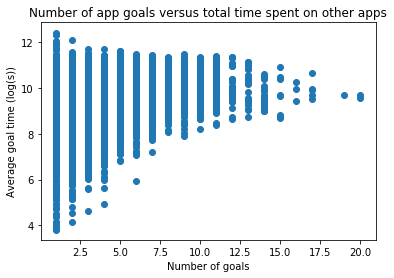

In [33]:
import matplotlib.pyplot as pyplot
import collections

most_active_users = {"": 0}
most_active_user = ""
for stat in day_stats:
    email = stat[HASH]
    if email not in most_active_users:
        most_active_users[email] = 0
    most_active_users[email] += 1
    if most_active_users[email] > most_active_users[most_active_user]:
        most_active_user = email
print(most_active_user)
pyplot.figure(43)
pyplot.title("Number of app goals versus total time spent on other apps")
pyplot.ylabel("Average goal time (log(s))")
pyplot.xlabel("Number of goals")
pyplot.scatter([len(stat[GOALS]) for stat in day_stats], [(stat[TOTAL_TIME]) for stat in day_stats])


In [34]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ intensity +  (1|email_hash) + (1|num_goals), data = df)
summary(results)

/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ intensity + (1 | email_hash) + (1 | num_goals)
   Data: df

REML criterion at convergence: 14015

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.1519 -0.4433  0.1128  0.5633  3.0215 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.25468  1.1201  
 num_goals  (Intercept) 0.01622  0.1274  
 Residual               0.73549  0.8576  
Number of obs: 4995, groups:  email_hash, 565; num_goals, 19

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    9.15270    0.07623   63.55178 120.062  < 2e-16 ***
intensity     -0.46208    0.17079 4836.70193  -2.706  0.00684 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.524


In [35]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(target_time ~ avg_goal_time + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: target_time ~ avg_goal_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 20008.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8607 -0.1570 -0.0475 -0.0138  5.3036 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.481    1.575   
 Residual               2.586    1.608   
Number of obs: 4995, groups:  email_hash, 565

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   7.264e-01  1.047e-01 1.516e+03   6.935 6.01e-12 ***
avg_goal_time 6.559e-02  3.337e-02 4.848e+03   1.966   0.0494 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_goal_tm -0.705


In [36]:
# see average change for time spent in goals vs. outside of goal when freq setting changes
from statistics import mean, StatisticsError
goal_time_change_stats = []
other_time_change_stats = []
user_stats = {}
max_time = 0
for day in day_stats:
    email = day[HASH]
    if day[HASH] not in user_stats:
        user_stats[email] = {FREQ_GOALS: set([]), INFREQ_GOALS: set([])}
    user_stats[email][FREQ_GOALS] = user_stats[email][FREQ_GOALS].union(day[FREQ_GOALS])
    user_stats[email][INFREQ_GOALS] = user_stats[email][INFREQ_GOALS].union(day[INFREQ_GOALS])
    for domain_time in day:
        if "_domain_time" in domain_time:
            domain = domain_time[:-len("_domain_time")]
            if domain not in user_stats[email]:
                user_stats[email][domain] = {"frequent_goal": [], "infrequent_goal": [], "frequent_other": [], "infrequent_other": []}
            if not (domain in day[FREQ_GOALS] and domain in day[INFREQ_GOALS]):
                freq = "frequent" if domain in day[FREQ_GOALS] else "infrequent"
                if day[domain_time] > max_time:
                    max_time = day[domain_time]
                    print(max_time)
                user_stats[email][domain][freq + "_goal"].append(day[domain_time])
                user_stats[email][domain][freq+"_other"].append(day[TOTAL_TIME] - day[domain_time])
for user in user_stats:
    for domain in user_stats[user][FREQ_GOALS].intersection(user_stats[user][INFREQ_GOALS]):
        if 0 not in user_stats[user][domain]["frequent_goal"] and 0 not in user_stats[user][domain]["infrequent_goal"]:
            try:
                mean_freq_goal = mean(user_stats[user][domain]["frequent_goal"])
                # print("frequent" + str(user_stats[user][domain]["frequent_goal"]))
                # print("infrequent  " + str(user_stats[user][domain]["infrequent_goal"]))
                goal_change = mean_freq_goal - mean(user_stats[user][domain]["infrequent_goal"])
                other_change = mean(user_stats[user][domain]["frequent_other"]) - mean(user_stats[user][domain]["infrequent_other"])
                goal_time_change_stats.append(goal_change)
                other_time_change_stats.append(other_change)
            except StatisticsError:
                pass

7.422373700986824
9.009202900924588
9.914625296946584
10.663124474364906
11.05668271897453
11.340082840810044


In [37]:

import pandas as pd
# our next data set: goal_time, freq, goal, and email_hash
goal_stats_dict = {"app": [], "email": [], "time": [], "other_time": [], "frequency": [], 'intensity_day': [], 'intensity_othergoals_day': []}
for day in day_stats:
    for key in day:
        if "domain_time" in key:
            domain = key[:-len("_domain_time")]
            if not (domain in day[FREQ_GOALS] and domain in day[INFREQ_GOALS]) and (domain in day[FREQ_GOALS] or domain in day[INFREQ_GOALS]):
                freq = "frequent" if domain in day[FREQ_GOALS] else "infrequent"
                print(str(day[INTENSITY]) + " " + str(day[domain + "_intervention_sessions"])+ " " + str(day["num_sessions"]))
                goal_stats_dict["intensity_othergoals_day"].append(day[INTENSITY] - day[domain + "_intervention_sessions"]/day["num_sessions"])
                goal_stats_dict["intensity_day"].append(day[INTENSITY])
                goal_stats_dict["app"].append(domain)
                goal_stats_dict["email"].append(day[HASH])
                goal_stats_dict["time"].append(day[key])
                goal_stats_dict["other_time"].append(day[GOAL_TIME] - day[key])
                goal_stats_dict["frequency"].append(freq)
goal_freq_df = pd.DataFrame(goal_stats_dict)
print(goal_freq_df)
#goal_freq_df.to_csv("goal_freq_df.csv")

0.16666666666666666 1 6
0.16666666666666666 0 6
0.13333333333333333 3 60
0.13333333333333333 2 60
0.13333333333333333 1 60
0.07142857142857142 1 14
0.07142857142857142 0 14
0.07042253521126761 0 71
0.07042253521126761 0 71
0.07042253521126761 2 71
0.0392156862745098 0 51
0.1873508353221957 1 838
0.13675213675213677 5 117
0.13675213675213677 6 117
0.13675213675213677 0 117
0.11504424778761062 4 113
0.11504424778761062 2 113
0.11504424778761062 0 113
0.13602941176470587 1 272
0.13602941176470587 8 272
0.13602941176470587 6 272
0.13602941176470587 0 272
0.13602941176470587 8 272
0.08264462809917356 1 121
0.08264462809917356 3 121
0.08264462809917356 0 121
0.037037037037037035 1 27
0.037037037037037035 0 27
0.013333333333333334 0 75
0.013333333333333334 1 75
0.0 0 52
0.0 0 52
0.07142857142857142 1 98
0.07142857142857142 2 98
0.07142857142857142 3 98
0.07142857142857142 0 98
0.3333333333333333 1 3
0.0547945205479452 3 219
0.0547945205479452 0 219
0.0547945205479452 3 219
0.1059322033898305 

0.2648648648648649 19 370
0.2648648648648649 30 370
0.2648648648648649 2 370
0.26384364820846906 4 307
0.26384364820846906 1 307
0.26384364820846906 16 307
0.26384364820846906 1 307
0.26384364820846906 5 307
0.26384364820846906 12 307
0.26384364820846906 1 307
0.20527859237536658 34 341
0.20527859237536658 1 341
0.20527859237536658 10 341
0.20527859237536658 1 341
0.20527859237536658 2 341
0.20527859237536658 1 341
0.20670391061452514 4 179
0.20670391061452514 3 179
0.20670391061452514 9 179
0.20670391061452514 4 179
0.263681592039801 4 201
0.263681592039801 3 201
0.263681592039801 19 201
0.263681592039801 5 201
0.263681592039801 0 201
0.263681592039801 1 201
0.19602272727272727 6 352
0.19602272727272727 4 352
0.19602272727272727 9 352
0.19602272727272727 5 352
0.19602272727272727 7 352
0.19602272727272727 1 352
0.2119700748129676 12 401
0.2119700748129676 0 401
0.2119700748129676 6 401
0.2119700748129676 14 401
0.2119700748129676 2 401
0.2119700748129676 14 401
0.2119700748129676 6 40

0.13800904977375567 16 442
0.13800904977375567 0 442
0.1276595744680851 20 470
0.1276595744680851 11 470
0.1276595744680851 2 470
0.1276595744680851 5 470
0.1276595744680851 0 470
0.1276595744680851 0 470
0.1111111111111111 18 720
0.1111111111111111 4 720
0.1111111111111111 11 720
0.1111111111111111 1 720
0.1111111111111111 0 720
0.1111111111111111 12 720
0.1111111111111111 0 720
0.16985645933014354 9 418
0.16985645933014354 2 418
0.16985645933014354 7 418
0.14642857142857144 0 280
0.14642857142857144 4 280
0.14642857142857144 0 280
0.14642857142857144 2 280
0.14642857142857144 6 280
0.14642857142857144 3 280
0.16289592760180996 1 442
0.16289592760180996 13 442
0.16289592760180996 11 442
0.16289592760180996 13 442
0.16289592760180996 2 442
0.16289592760180996 0 442
0.14136125654450263 2 382
0.14136125654450263 12 382
0.14136125654450263 3 382
0.14136125654450263 0 382
0.14136125654450263 6 382
0.14136125654450263 1 382
0.1291390728476821 3 604
0.1291390728476821 2 604
0.129139072847682

0.1380952380952381 19 420
0.1380952380952381 3 420
0.1380952380952381 1 420
0.1380952380952381 1 420
0.1771117166212534 6 367
0.1771117166212534 0 367
0.1771117166212534 4 367
0.1771117166212534 8 367
0.1771117166212534 17 367
0.2900763358778626 1 524
0.2900763358778626 17 524
0.2900763358778626 22 524
0.2900763358778626 25 524
0.2900763358778626 1 524
0.32967032967032966 32 364
0.32967032967032966 10 364
0.32967032967032966 25 364
0.32967032967032966 2 364
0.32967032967032966 1 364
0.28164556962025317 9 316
0.28164556962025317 6 316
0.28164556962025317 32 316
0.28164556962025317 13 316
0.28164556962025317 3 316
0.34124629080118696 45 337
0.34124629080118696 0 337
0.34124629080118696 23 337
0.34124629080118696 11 337
0.34124629080118696 0 337
0.34124629080118696 2 337
0.23255813953488372 18 344
0.23255813953488372 24 344
0.23255813953488372 1 344
0.23255813953488372 0 344
0.23255813953488372 0 344
0.23255813953488372 1 344
0.21238938053097345 8 452
0.21238938053097345 34 452
0.21238938

0.3637295081967213 288 976
0.3637295081967213 8 976
0.3637295081967213 31 976
0.3637295081967213 7 976
0.3637295081967213 4 976
0.3248239436619718 49 1136
0.3248239436619718 299 1136
0.3248239436619718 1 1136
0.3248239436619718 15 1136
0.2360248447204969 248 1449
0.2360248447204969 17 1449
0.2360248447204969 15 1449
0.2360248447204969 52 1449
0.222692633361558 231 1181
0.222692633361558 20 1181
0.222692633361558 8 1181
0.24174174174174173 290 1332
0.24174174174174173 12 1332
0.24174174174174173 8 1332
0.197327852004111 23 973
0.197327852004111 6 973
0.08217592592592593 19 864
0.08217592592592593 42 864
0.08217592592592593 3 864
0.08636052090472926 91 1459
0.08636052090472926 21 1459
0.08636052090472926 5 1459
0.08763784097504353 90 1723
0.08763784097504353 3 1723
0.08763784097504353 27 1723
0.11827956989247312 52 1116
0.11827956989247312 3 1116
0.11827956989247312 55 1116
0.09206081081081081 35 1184
0.09206081081081081 4 1184
0.09206081081081081 40 1184
0.048795944233206594 11 1578
0.0

0.13373253493013973 59 1002
0.13373253493013973 6 1002
0.13373253493013973 16 1002
0.13373253493013973 9 1002
0.11322463768115942 8 1104
0.11322463768115942 55 1104
0.11322463768115942 4 1104
0.11322463768115942 8 1104
0.10902255639097744 38 1064
0.10902255639097744 8 1064
0.10902255639097744 17 1064
0.10902255639097744 12 1064
0.10902255639097744 2 1064
0.10177705977382875 84 1857
0.10177705977382875 21 1857
0.10177705977382875 25 1857
0.10177705977382875 7 1857
0.10177705977382875 1 1857
0.12025316455696203 16 790
0.12025316455696203 22 790
0.12025316455696203 20 790
0.12025316455696203 5 790
0.12025316455696203 8 790
0.1602136181575434 14 1498
0.31291946308724833 231 1192
0.31291946308724833 33 1192
0.31291946308724833 57 1192
0.31291946308724833 6 1192
0.31291946308724833 2 1192
0.3098995695839311 216 1394
0.3098995695839311 120 1394
0.3098995695839311 52 1394
0.3098995695839311 8 1394
0.3098995695839311 5 1394
0.30594594594594593 175 925
0.30594594594594593 52 925
0.30594594594594

0.19155844155844157 41 616
0.19155844155844157 20 616
0.19155844155844157 29 616
0.19155844155844157 0 616
0.3076923076923077 3 325
0.3076923076923077 53 325
0.3076923076923077 1 325
0.3076923076923077 32 325
0.3076923076923077 0 325
0.15488215488215487 2 297
0.15488215488215487 15 297
0.15488215488215487 17 297
0.25902335456475584 53 471
0.25902335456475584 47 471
0.25902335456475584 3 471
0.25902335456475584 10 471
0.2021505376344086 19 465
0.2021505376344086 22 465
0.2021505376344086 25 465
0.2021505376344086 12 465
0.225531914893617 25 705
0.225531914893617 32 705
0.225531914893617 13 705
0.225531914893617 59 705
0.225531914893617 0 705
0.23842195540308747 10 583
0.23842195540308747 24 583
0.23842195540308747 7 583
0.23842195540308747 46 583
0.35084745762711866 22 590
0.35084745762711866 22 590
0.35084745762711866 21 590
0.35084745762711866 0 590
0.35084745762711866 92 590
0.30637636080870917 35 643
0.30637636080870917 16 643
0.30637636080870917 45 643
0.30637636080870917 13 643
0.

0.15982721382289417 9 463
0.15982721382289417 1 463
0.1402805611222445 9 499
0.1402805611222445 5 499
0.1402805611222445 1 499
0.1402805611222445 1 499
0.1402805611222445 0 499
0.16023738872403562 4 337
0.16023738872403562 3 337
0.16023738872403562 1 337
0.16023738872403562 0 337
0.1552346570397112 4 554
0.1552346570397112 3 554
0.1552346570397112 3 554
0.1552346570397112 0 554
0.1552346570397112 1 554
0.08695652173913043 1 46
0.08695652173913043 1 46
0.1 1 10
0.31645569620253167 9 79
0.31645569620253167 0 79
0.31645569620253167 5 79
0.1643835616438356 11 219
0.1643835616438356 0 219
0.1643835616438356 0 219
0.1643835616438356 1 219
0.25 4 24
0.25 2 24
0.48381877022653724 1 618
0.48381877022653724 13 618
0.48381877022653724 3 618
0.48381877022653724 12 618
0.48381877022653724 1 618
0.48381877022653724 0 618
0.4727061556329849 1 861
0.4727061556329849 27 861
0.4727061556329849 2 861
0.4727061556329849 1 861
0.4727061556329849 2 861
0.4727061556329849 8 861
0.4727061556329849 3 861
0.472

0.031746031746031744 5 378
0.01855287569573284 5 539
0.01855287569573284 1 539
0.016194331983805668 1 247
0.0036231884057971015 1 276
0.04335260115606936 10 346
0.028423772609819122 8 387
0.018912529550827423 7 423
0.18421052631578946 1 38
0.18421052631578946 2 38
0.24074074074074073 2 108
0.24074074074074073 8 108
0.24074074074074073 1 108
0.24074074074074073 1 108
0.25 1 32
0.25 5 32
0.4782608695652174 37 115
0.4782608695652174 5 115
0.2558139534883721 14 86
0.2558139534883721 3 86
0.22442244224422442 16 303
0.22442244224422442 12 303
0.22442244224422442 5 303
0.22442244224422442 8 303
0.24561403508771928 4 57
0.24561403508771928 6 57
0.24561403508771928 2 57
0.24561403508771928 0 57
0.21323529411764705 9 136
0.21323529411764705 7 136
0.19791666666666666 12 192
0.19791666666666666 7 192
0.10546875 10 256
0.10546875 3 256
0.08368200836820083 13 239
0.08368200836820083 1 239
0.10601719197707736 15 349
0.07392996108949416 12 257
0.07392996108949416 1 257
0.2729528535980149 7 403
0.27295

0.31393298059964725 5 567
0.31393298059964725 4 567
0.31393298059964725 3 567
0.31393298059964725 19 567
0.3016845329249617 25 653
0.3016845329249617 86 653
0.3016845329249617 1 653
0.3016845329249617 5 653
0.3016845329249617 16 653
0.3016845329249617 44 653
0.3016845329249617 4 653
0.3016845329249617 0 653
0.3016845329249617 4 653
0.3016845329249617 4 653
0.3016845329249617 1 653
0.38309859154929576 6 355
0.38309859154929576 43 355
0.38309859154929576 3 355
0.38309859154929576 47 355
0.38309859154929576 9 355
0.38309859154929576 4 355
0.38309859154929576 7 355
0.38309859154929576 1 355
0.38309859154929576 3 355
0.38309859154929576 0 355
0.405982905982906 34 468
0.405982905982906 60 468
0.405982905982906 10 468
0.405982905982906 6 468
0.405982905982906 2 468
0.405982905982906 11 468
0.405982905982906 39 468
0.405982905982906 0 468
0.405982905982906 2 468
0.405982905982906 0 468
0.4072164948453608 23 582
0.4072164948453608 15 582
0.4072164948453608 17 582
0.4072164948453608 6 582
0.4072

0.3333333333333333 14 60
0.3333333333333333 2 60
0.0913978494623656 8 186
0.09142857142857143 8 175
0.06944444444444445 7 144
0.04516129032258064 3 155
0.10204081632653061 4 147
0.10423452768729642 13 307
0.08585858585858586 11 198
0.09859154929577464 12 213
0.11538461538461539 11 234
0.13257575757575757 15 264
0.10429447852760736 7 163
0.09022556390977443 11 266
0.04142011834319527 2 169
0.11158798283261803 3 233
0.06282722513089005 2 382
0.04404145077720207 2 386
0.04 0 300
0.06642066420664207 5 271
0.027777777777777776 1 252
0.06976744186046512 7 215
0.15 12 180
0.09009009009009009 13 222
0.11808118081180811 19 271
0.08273381294964029 6 278
0.07434944237918216 11 269
0.06015037593984962 6 266
0.1794871794871795 0 117
0.1794871794871795 3 117
0.1794871794871795 0 117
0.1794871794871795 1 117
0.1794871794871795 1 117
0.1794871794871795 0.0 117
0.1794871794871795 2 117
0.1981981981981982 1 111
0.1981981981981982 0 111
0.1981981981981982 3 111
0.1981981981981982 1 111
0.1981981981981982

0.27702702702702703 4 148
0.27702702702702703 2 148
0.3686868686868687 2 198
0.3686868686868687 5 198
0.3686868686868687 56 198
0.3686868686868687 4 198
0.3686868686868687 1 198
0.3686868686868687 1 198
0.4117647058823529 17 102
0.4117647058823529 2 102
0.4117647058823529 1 102
0.4117647058823529 6 102
0.4117647058823529 6 102
0.4117647058823529 8 102
0.3125 0 176
0.3125 4 176
0.3125 10 176
0.3125 2 176
0.3125 35 176
0.3125 2 176
0.387434554973822 3 191
0.387434554973822 49 191
0.387434554973822 1 191
0.387434554973822 11 191
0.387434554973822 6 191
0.387434554973822 1 191
0.2727272727272727 6 154
0.2727272727272727 4 154
0.2727272727272727 19 154
0.2727272727272727 2 154
0.2727272727272727 2 154
0.2727272727272727 7 154
0.376 25 125
0.376 3 125
0.376 13 125
0.376 0 125
0.376 4 125
0.3226837060702875 67 313
0.3226837060702875 18 313
0.3226837060702875 1 313
0.3226837060702875 3 313
0.3226837060702875 10 313
0.3226837060702875 0 313
0.41818181818181815 4 165
0.41818181818181815 20 165
0

0.2 23 365
0.18811881188118812 12 303
0.18811881188118812 25 303
0.1941747572815534 23 309
0.1941747572815534 12 309
0.22259136212624583 26 301
0.22259136212624583 14 301
0.18333333333333332 12 240
0.18333333333333332 9 240
0.29743589743589743 6 195
0.29743589743589743 21 195
0.18345323741007194 10 278
0.20833333333333334 1 72
0.20833333333333334 2 72
0.20833333333333334 2 72
0.1794871794871795 8 195
0.1794871794871795 1 195
0.1794871794871795 0 195
0.1794871794871795 5 195
0.23039215686274508 1 204
0.23039215686274508 4 204
0.23039215686274508 2 204
0.23039215686274508 1 204
0.23039215686274508 4 204
0.3712121212121212 5 264
0.3712121212121212 15 264
0.3712121212121212 2 264
0.3712121212121212 8 264
0.3712121212121212 18 264
0.3712121212121212 7 264
0.3502824858757062 2 177
0.3502824858757062 16 177
0.3502824858757062 5 177
0.3502824858757062 10 177
0.3502824858757062 2 177
0.26582278481012656 10 316
0.26582278481012656 7 316
0.26582278481012656 9 316
0.26582278481012656 25 316
0.2658

0.3611111111111111 2 144
0.3611111111111111 1 144
0.3611111111111111 0 144
0.3611111111111111 2 144
0.3442622950819672 16 183
0.3442622950819672 14 183
0.3442622950819672 3 183
0.3442622950819672 1 183
0.3442622950819672 0 183
0.3442622950819672 2 183
0.3442622950819672 0 183
0.3442622950819672 0 183
0.3271604938271605 0 162
0.3271604938271605 1 162
0.3271604938271605 1 162
0.3271604938271605 7 162
0.3271604938271605 6 162
0.3271604938271605 1 162
0.3271604938271605 0 162
0.3271604938271605 2 162
0.3271604938271605 1 162
0.3271604938271605 1 162
0.3271604938271605 0 162
0.3271604938271605 2 162
0.3114754098360656 1 183
0.3114754098360656 9 183
0.3114754098360656 0 183
0.3114754098360656 1 183
0.3114754098360656 10 183
0.18181818181818182 2 11
0.25 1 28
0.25 4 28
0.25 2 28
0.28205128205128205 5 39
0.28205128205128205 2 39
0.28205128205128205 2 39
0.28205128205128205 2 39
0.14864864864864866 5 222
0.14864864864864866 6 222
0.14864864864864866 22 222
0.10743801652892562 4 121
0.1074380165

0.34411764705882353 1 340
0.34411764705882353 28 340
0.34411764705882353 19 340
0.34411764705882353 18 340
0.34411764705882353 3 340
0.34411764705882353 30 340
0.34411764705882353 0 340
0.34411764705882353 0 340
0.34411764705882353 5 340
0.1237785016286645 0 307
0.1237785016286645 2 307
0.1237785016286645 4 307
0.1237785016286645 14 307
0.1237785016286645 1 307
0.1237785016286645 5 307
0.1482213438735178 15 506
0.1482213438735178 16 506
0.1482213438735178 3 506
0.1482213438735178 6 506
0.20642201834862386 4 218
0.20642201834862386 3 218
0.20642201834862386 1 218
0.08552631578947369 1 304
0.08552631578947369 6 304
0.08552631578947369 1 304
0.1187214611872146 4 219
0.1187214611872146 2 219
0.15966386554621848 12 476
0.15966386554621848 3 476
0.15966386554621848 6 476
0.15966386554621848 4 476
0.15966386554621848 22 476
0.16789667896678967 47 542
0.16789667896678967 3 542
0.16789667896678967 5 542
0.09644670050761421 14 591
0.09644670050761421 9 591
0.09644670050761421 1 591
0.09644670050

0.11616161616161616 0.0 198
0.11616161616161616 4 198
0.11616161616161616 0 198
0.11616161616161616 2 198
0.08536585365853659 2 164
0.08536585365853659 0 164
0.08536585365853659 1 164
0.0379746835443038 1 237
0.09375 0 160
0.09375 0 160
0.07942238267148015 4 277
0.07942238267148015 0 277
0.07942238267148015 0 277
0.10784313725490197 10 204
0.10784313725490197 0 204
0.06168831168831169 2 308
0.07861369399830938 0 1183
0.1377952755905512 5 254
0.1377952755905512 2 254
0.29809725158562367 3 473
0.29809725158562367 2 473
0.29809725158562367 0 473
0.29809725158562367 0 473
0.29809725158562367 1 473
0.29809725158562367 1 473
0.29809725158562367 1 473
0.29809725158562367 2 473
0.21973929236499068 2 537
0.21973929236499068 0 537
0.21973929236499068 0 537
0.21973929236499068 15 537
0.21973929236499068 4 537
0.21973929236499068 0 537
0.21973929236499068 1 537
0.21973929236499068 0 537
0.21973929236499068 9 537
0.21973929236499068 1 537
0.1737704918032787 2 305
0.1737704918032787 8 305
0.17377049

0.39204545454545453 3 176
0.39204545454545453 0 176
0.34105960264900664 0 302
0.34105960264900664 59 302
0.34105960264900664 11 302
0.34105960264900664 8 302
0.34105960264900664 3 302
0.34105960264900664 2 302
0.4342857142857143 0 175
0.4342857142857143 3 175
0.37988826815642457 8 179
0.37988826815642457 41 179
0.37988826815642457 1 179
0.37988826815642457 1 179
0.37988826815642457 0 179
0.40860215053763443 58 186
0.40860215053763443 6 186
0.40860215053763443 2 186
0.40860215053763443 3 186
0.40860215053763443 0 186
0.46153846153846156 8 143
0.46153846153846156 4 143
0.46153846153846156 44 143
0.46153846153846156 1 143
0.46153846153846156 0 143
0.4161490683229814 10 161
0.4161490683229814 17 161
0.4161490683229814 5 161
0.4161490683229814 27 161
0.4161490683229814 0 161
0.4272300469483568 11 213
0.4272300469483568 15 213
0.4272300469483568 40 213
0.4272300469483568 6 213
0.4272300469483568 0 213
0.40375586854460094 35 213
0.40375586854460094 9 213
0.40375586854460094 13 213
0.403755868

0.298582995951417 1 988
0.298582995951417 0 988
0.327796234772979 38 903
0.327796234772979 74 903
0.327796234772979 0 903
0.327796234772979 1 903
0.327796234772979 111 903
0.327796234772979 0 903
0.327796234772979 1 903
0.327796234772979 3 903
0.327796234772979 4 903
0.30935251798561153 12 695
0.30935251798561153 81 695
0.30935251798561153 0 695
0.30935251798561153 81 695
0.30935251798561153 4 695
0.30935251798561153 1 695
0.30935251798561153 1 695
0.30935251798561153 0 695
0.3834048640915594 80 699
0.3834048640915594 120 699
0.3834048640915594 4 699
0.3834048640915594 0 699
0.3834048640915594 1 699
0.4181957186544342 136 1308
0.4181957186544342 178 1308
0.4181957186544342 208 1308
0.4181957186544342 2 1308
0.4181957186544342 0 1308
0.4181957186544342 3 1308
0.4034151547491996 136 937
0.4034151547491996 159 937
0.4034151547491996 70 937
0.4034151547491996 0 937
0.4034151547491996 1 937
0.4034151547491996 1 937
0.4034151547491996 1 937
0.4034151547491996 2 937
0.3996003996003996 103 100

0.42738589211618255 1 241
0.42738589211618255 5 241
0.42738589211618255 1 241
0.41333333333333333 5 150
0.41333333333333333 6 150
0.41333333333333333 11 150
0.41333333333333333 0 150
0.41333333333333333 4 150
0.41333333333333333 4 150
0.41333333333333333 6 150
0.41333333333333333 16 150
0.41333333333333333 1 150
0.3447488584474886 36 438
0.3447488584474886 8 438
0.3447488584474886 9 438
0.3447488584474886 8 438
0.3447488584474886 23 438
0.3447488584474886 5 438
0.3447488584474886 15 438
0.3447488584474886 5 438
0.3447488584474886 1 438
0.3447488584474886 4 438
0.3447488584474886 2.8903717578961645 438
0.3447488584474886 0 438
0.3447488584474886 1 438
0.3447488584474886 0 438
0.3447488584474886 0 438
0.3447488584474886 0 438
0.3591549295774648 5 142
0.3591549295774648 0 142
0.3591549295774648 2 142
0.3591549295774648 4 142
0.3591549295774648 10 142
0.3591549295774648 3 142
0.3591549295774648 4 142
0.3591549295774648 4 142
0.375 8 120
0.375 2 120
0.375 9 120
0.375 1 120
0.375 6 120
0.375

0.3458498023715415 17 506
0.22928709055876687 15 519
0.22928709055876687 46 519
0.22928709055876687 4 519
0.22928709055876687 8 519
0.16209476309226933 11 401
0.16209476309226933 11 401
0.16209476309226933 0 401
0.16209476309226933 3 401
0.1559633027522936 1 218
0.1559633027522936 1 218
0.1559633027522936 3 218
0.14760147601476015 7 271
0.14760147601476015 5 271
0.13793103448275862 14 435
0.13793103448275862 8 435
0.13793103448275862 0 435
0.13793103448275862 4 435
0.17633410672853828 16 431
0.17633410672853828 13 431
0.17633410672853828 4 431
0.16201117318435754 13 537
0.16201117318435754 13 537
0.16201117318435754 3 537
0.13572854291417166 18 501
0.13572854291417166 3 501
0.13572854291417166 1 501
0.2545454545454545 7 55
0.2545454545454545 1 55
0.2545454545454545 1 55
0.2677165354330709 9 254
0.2677165354330709 9 254
0.2677165354330709 11 254
0.2677165354330709 0 254
0.2677165354330709 2 254
0.365 9 200
0.365 3 200
0.365 14 200
0.365 1 200
0.365 8 200
0.34843205574912894 9 287
0.3484

0.27835051546391754 0 194
0.22764227642276422 15 246
0.22764227642276422 4 246
0.1984126984126984 4 126
0.1984126984126984 0 126
0.2736156351791531 32 307
0.2736156351791531 5 307
0.2736156351791531 3 307
0.2736156351791531 1 307
0.2736156351791531 4 307
0.2736156351791531 1.0986122886681098 307
0.2736156351791531 7 307
0.2736156351791531 1 307
0.2736156351791531 2 307
0.2736156351791531 0 307
0.2079646017699115 56 678
0.2079646017699115 1.6094379124341003 678
0.2079646017699115 0 678
0.2079646017699115 2 678
0.2079646017699115 2 678
0.2079646017699115 12 678
0.2079646017699115 0 678
0.2079646017699115 2 678
0.1933139534883721 76 688
0.1933139534883721 1.6094379124341003 688
0.1933139534883721 1 688
0.1933139534883721 1 688
0.1933139534883721 1 688
0.1933139534883721 12 688
0.1933139534883721 1 688
0.1933139534883721 2 688
0.1933139534883721 0 688
0.2074688796680498 1 723
0.2074688796680498 1.9459101490553132 723
0.2074688796680498 23 723
0.2074688796680498 71 723
0.2074688796680498 1 

0.15384615384615385 8 507
0.13275613275613277 5 693
0.17857142857142858 1 28
0.13043478260869565 2 69
0.13043478260869565 1 69
0.13043478260869565 1 69
0.13043478260869565 0 69
0.09523809523809523 0 84
0.09523809523809523 3 84
0.10526315789473684 0 95
0.10526315789473684 0 95
0.07534246575342465 0 146
0.07534246575342465 1 146
0.3619047619047619 23 210
0.3619047619047619 6 210
0.3619047619047619 2 210
0.3619047619047619 4 210
0.3619047619047619 0 210
0.3619047619047619 6 210
0.23369565217391305 1 184
0.23369565217391305 3 184
0.23369565217391305 10 184
0.23369565217391305 2 184
0.23369565217391305 3 184
0.23369565217391305 0 184
0.23369565217391305 3 184
0.23369565217391305 2 184
0.23369565217391305 1 184
0.12195121951219512 0 41
0.12195121951219512 1 41
0.12195121951219512 0 41
0.12195121951219512 1 41
0.3541666666666667 5 144
0.3541666666666667 7 144
0.3541666666666667 0 144
0.3541666666666667 10 144
0.3541666666666667 5 144
0.3541666666666667 3 144
0.3541666666666667 0 144
0.3541666

0.12217194570135746 6 221
0.12217194570135746 1 221
0.13924050632911392 17 158
0.13924050632911392 4 158
0.19875776397515527 12 161
0.19875776397515527 6 161
0.19875776397515527 3 161
0.19875776397515527 3 161
0.16759776536312848 10 179
0.16759776536312848 4 179
0.16759776536312848 9 179
0.242914979757085 10 247
0.242914979757085 32 247
0.242914979757085 1 247
0.242914979757085 13 247
0.16756756756756758 7 185
0.16756756756756758 6 185
0.16756756756756758 6 185
0.2540983606557377 6 122
0.2540983606557377 11 122
0.2540983606557377 3 122
0.2540983606557377 9 122
0.27102803738317754 22 214
0.27102803738317754 9 214
0.27102803738317754 17 214
0.27102803738317754 6 214
0.2125 12 80
0.2125 1 80
0.2125 2 80
0.16923076923076924 5 130
0.16923076923076924 9 130
0.16923076923076924 7 130
0.16923076923076924 1 130
0.21311475409836064 18 122
0.21311475409836064 1 122
0.21311475409836064 2 122
0.4943181818181818 38 176
0.4943181818181818 18 176
0.4943181818181818 10 176
0.4943181818181818 12 176
0.4

0.1715686274509804 54 408
0.1715686274509804 1 408
0.1715686274509804 1 408
0.1715686274509804 1 408
0.1715686274509804 1 408
0.19662921348314608 7 178
0.19662921348314608 24 178
0.19662921348314608 1 178
0.19662921348314608 0 178
0.2123076923076923 50 325
0.2123076923076923 2 325
0.2123076923076923 10 325
0.2123076923076923 4 325
0.2785388127853881 107 438
0.2785388127853881 2 438
0.2785388127853881 10 438
0.2785388127853881 1 438
0.2732919254658385 66 322
0.2732919254658385 8 322
0.2732919254658385 1 322
0.2732919254658385 1 322
0.2732919254658385 5 322
0.2631578947368421 31 209
0.2631578947368421 11 209
0.19491525423728814 0 236
0.19491525423728814 10 236
0.19491525423728814 9 236
0.19491525423728814 7 236
0.19491525423728814 1 236
0.19491525423728814 4 236
0.19491525423728814 0 236
0.20614035087719298 9 684
0.20614035087719298 38 684
0.20614035087719298 9 684
0.20614035087719298 34 684
0.20614035087719298 5 684
0.20614035087719298 1 684
0.20614035087719298 1 684
0.20614035087719298

In [38]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200

goal_freq_df <- subset(goal_freq_df, intensity_othergoals_day != -1)
summary(goal_freq_df)

/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


     app               email                time          other_time    
 Length:28267       Length:28267       Min.   : 0.000   Min.   : 0.000  
 Class :character   Class :character   1st Qu.: 4.916   1st Qu.: 1.060  
 Mode  :character   Mode  :character   Median : 6.389   Median : 2.180  
                                       Mean   : 6.130   Mean   : 2.530  
                                       3rd Qu.: 7.551   3rd Qu.: 3.662  
                                       Max.   :11.340   Max.   :11.259  
  frequency         intensity_day    intensity_othergoals_day
 Length:28267       Min.   :0.0000   Min.   :-0.5000         
 Class :character   1st Qu.:0.1476   1st Qu.: 0.1176         
 Mode  :character   Median :0.2197   Median : 0.1852         
                    Mean   :0.2308   Mean   : 0.1982         
                    3rd Qu.:0.3021   3rd Qu.: 0.2663         
                    Max.   :0.7963   Max.   : 0.7037         


In [39]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-MOBILE-SYMBIOTIC

goal_freq_df <- subset(goal_freq_df, intensity_othergoals_day != -1)

# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
#results <- lmer(time ~ intensity_othergoals_day + (1|frequency), data = goal_freq_df)
results <- lmer(time ~ intensity_othergoals_day + (frequency) + (1|app), data = goal_freq_df)
#results <- lmer(time ~ intensity_othergoals_day + (1|frequency) + (1|app) + (1|email), data = goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ intensity_othergoals_day + (frequency) + (1 | app)
   Data: goal_freq_df

REML criterion at convergence: 111650.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6961 -0.5596  0.1255  0.6707  3.4336 

Random effects:
 Groups   Name        Variance Std.Dev.
 app      (Intercept) 1.824    1.350   
 Residual             2.921    1.709   
Number of obs: 28267, groups:  app, 730

Fixed effects:
                           Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               5.598e+00  6.521e-02  8.010e+02  85.840   <2e-16 ***
intensity_othergoals_day -1.970e+00  1.021e-01  2.823e+04 -19.288   <2e-16 ***
frequencyfrequent        -5.983e-02  2.084e-02  2.810e+04  -2.871   0.0041 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) intn__
intnsty_th_ -0.324       
frqncyfrqnt -0.150 -0.0

In [40]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-MOBILE-REDUCED

# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
goal_freq_df$frequency <- goal_freq_df$frequency == 'frequent'
results <- t.test(goal_freq_df$time ~ goal_freq_df$frequency)
show(results)


	Welch Two Sample t-test

data:  goal_freq_df$time by goal_freq_df$frequency
t = 2.0232, df = 28264, p-value = 0.04306
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.001442951 0.091000960
sample estimates:
mean in group FALSE  mean in group TRUE 
           6.153100            6.106878 



In [41]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-MOBILE-REDUCED

# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lm(time ~ frequency, data = goal_freq_df)
summary(results)


Call:
lm(formula = time ~ frequency, data = goal_freq_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1531 -1.2115  0.2571  1.4189  5.1870 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        6.15310    0.01611 381.932   <2e-16 ***
frequencyfrequent -0.04622    0.02285  -2.023   0.0431 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.921 on 28265 degrees of freedom
Multiple R-squared:  0.0001448,	Adjusted R-squared:  0.0001094 
F-statistic: 4.093 on 1 and 28265 DF,  p-value: 0.04308



In [42]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-MOBILE-REDUCED

# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|app) , data = goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | app)
   Data: goal_freq_df

REML criterion at convergence: 112017.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5222 -0.5685  0.1263  0.6718  3.4655 

Random effects:
 Groups   Name        Variance Std.Dev.
 app      (Intercept) 1.819    1.349   
 Residual             2.960    1.721   
Number of obs: 28267, groups:  app, 730

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.193e+00  6.176e-02  6.510e+02  84.070  < 2e-16 ***
frequencyfrequent -6.715e-02  2.098e-02  2.811e+04  -3.201  0.00137 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.166


In [43]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-MOBILE-REDUCED

# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|app) + (1|email) , data = goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | app) + (1 | email)
   Data: goal_freq_df

REML criterion at convergence: 109873.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1108 -0.5408  0.1291  0.6559  3.7499 

Random effects:
 Groups   Name        Variance Std.Dev.
 app      (Intercept) 1.7958   1.3401  
 email    (Intercept) 0.5138   0.7168  
 Residual             2.6354   1.6234  
Number of obs: 28267, groups:  app, 730; email, 616

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.239e+00  6.936e-02  9.419e+02  75.532  < 2e-16 ***
frequencyfrequent -6.280e-02  2.062e-02  2.806e+04  -3.045  0.00233 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.142


1461
0.49828884325804246
[-0.07322227461659792, 0.04878211534612563]


<BarContainer object of 2 artists>

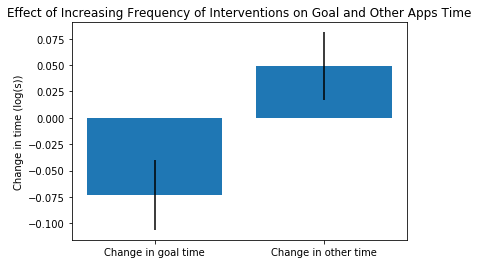

In [44]:
from scipy.stats import sem
pyplot.figure(32)
print(len(goal_time_change_stats))
pyplot.title("Effect of Increasing Frequency of Interventions on Goal and Other Apps Time")
pyplot.ylabel('Change in time (log(s))')
print(len([stat for stat in other_time_change_stats if stat > 0])/len(goal_time_change_stats))
print([mean(goal_time_change_stats), mean(other_time_change_stats)])
pyplot.bar(["Change in goal time", "Change in other time"], [mean(goal_time_change_stats), mean(other_time_change_stats)] , .8, yerr=[sem(goal_time_change_stats), sem(other_time_change_stats)])

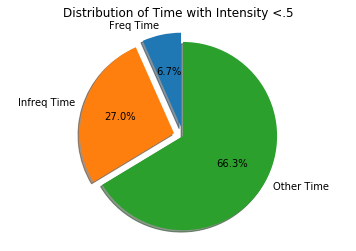

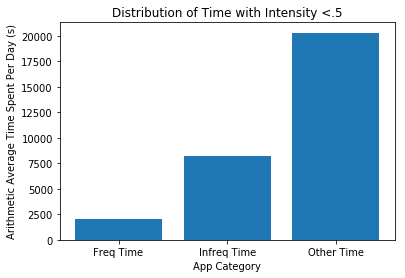

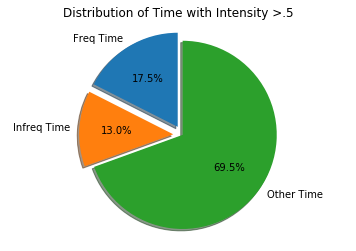

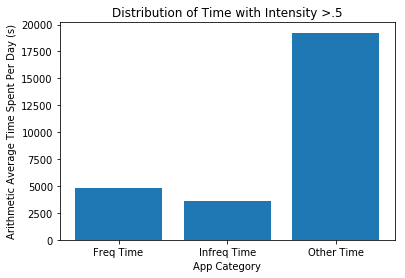

In [45]:

freq_time = [0,0]
infreq_time = [0,0]
other_time = [0,0]
num_days = [0, 0]
for day in day_stats:
    if len(day[FREQ_GOALS]) > 0 and len(day[INFREQ_GOALS]) > 0:
        intensity= len(day[FREQ_GOALS])/len(day[INFREQ_GOALS])
        if intensity <.5:
            num_days[0] += 1
            freq_time[0] += math.exp(day[FREQ_TIME])
            infreq_time[0] += math.exp(day[GOAL_TIME])-math.exp(day[FREQ_TIME])
            other_time[0] += math.exp(day[OTHER_TIME])
        elif intensity > .5:
            num_days[1] += 1
            freq_time[1] += math.exp(day[FREQ_TIME])
            infreq_time[1] += math.exp(day[GOAL_TIME])-math.exp(day[FREQ_TIME])
            other_time[1] += math.exp(day[OTHER_TIME])   
from functools import reduce
import numpy as np
for i in range(0,2):
    pyplot.figure(325 + i * 2 - 1)
    labels = 'Freq Time', 'Infreq Time', 'Other Time'
    sizes = [freq_time[i], infreq_time[i], other_time[i]]
    explode = (0.1, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    pyplot.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    pyplot.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    pyplot.title("Distribution of Time with Intensity " + ("<" if i == 0 else ">") + ".5")
    pyplot.figure(325 + i * 2)
    pyplot.title("Distribution of Time with Intensity " + ("<" if i == 0 else ">") + ".5")
    pyplot.xlabel("App Category")
    pyplot.ylabel("Arithmetic Average Time Spent Per Day (s)")
    pyplot.bar(labels, list(map(lambda x: x/num_days[i], sizes)))
    pyplot.figure("Distribution of Time with Intensity")


-0.7253974927488827


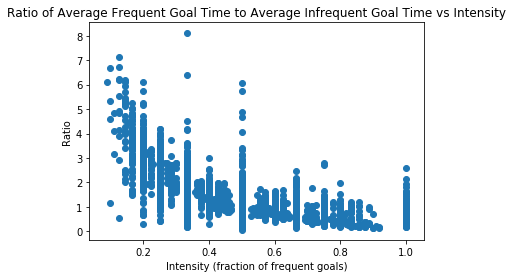

In [46]:
intensities = []
avg_freq_time = []
avg_infreq_time = []
ratio = []
for item in day_stats:
    if len(item[FREQ_GOALS]) > 0 and len(item[INFREQ_GOALS]) > 0 and math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME]) > 3:
        avg_freq_time_pt = item[FREQ_TIME]/len(item[FREQ_GOALS])
        
        avg_infreq_time_pt = math.log(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME]))/len(item[INFREQ_GOALS])
        if avg_freq_time_pt/avg_infreq_time_pt > 1000:
            print(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME]))
            print(math.log(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME])))
            print(math.log(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME]))/len(item[INFREQ_GOALS]))
            print(str(avg_freq_time_pt) + " " + str(avg_infreq_time_pt))
        intensity = len(item[FREQ_GOALS])/(len(item[FREQ_GOALS].union(item[INFREQ_GOALS])))
        if avg_freq_time_pt > 0 and avg_infreq_time_pt > 0:
            intensities.append(intensity)
            avg_freq_time.append(avg_freq_time_pt)
            avg_infreq_time.append(avg_infreq_time_pt)
            ratio.append((avg_freq_time_pt/avg_infreq_time_pt))
pyplot.figure(62426)
pyplot.title("Ratio of Average Frequent Goal Time to Average Infrequent Goal Time vs Intensity")
pyplot.xlabel("Intensity (fraction of frequent goals)")
pyplot.ylabel("Ratio")
pyplot.scatter(intensities, ratio)
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(intensities,ratio)
print(r_value)

In [102]:
user_to_install = json.loads(req.urlopen("http://localhost:5001/get_user_to_all_install_ids?user").read().decode("utf-8"))

In [103]:
print(user_to_install)

{'cf70413fe85715ab736d333f': [None], 'c8ade6084f86c3b0129b602d': [None], 'f8a42556cd4ada7cc5f1c67c': [None], 'b2621ff0fa270c69bdb23d21': [None], '71a5c986ecb0690185260a21': [None], '60ad1813dfba47427e8ccdeb': [None], '32be97c9200442a735f74afd': [None], '90322297bc000b106576432e': [None], '088568790f633275a926736c': [None], '8592a26e29e6dc83ff39fdb9': [None], '60a5c8391e1eadfe30796c9b': [None], 'c81167f7975e5f41fbd470f0': [None], 'd2022c6b792604cc53ae0bbf': [None], '92534ea2ca9da88f34aba3ee': [None], 'c1578167a57a817ee6269e05': [None], '63fe884ab73eb33a9cfcc4c5': [None, None], 'a5ced5e20af545f9e1022f7d': [None, None], '324aab5f9ddd9504cbb8223b': [None, None], '0709700f9fab67962cd18780': [None, None], 'e3418c5264dacec8a46b85c8': [None], '46b859e60de86b46b278bd14': [None], 'c7f9593373e5a8f977c5dc96': [None], '525fedbd18bf2d72a442432c': [None], 'c0ca58495c67ea92beba812d': [None], 'd3e259678a40bce2b64e880d': [None], '35d34c7105c8c0f849464244': [None], '4be1207cae1c38d16ad66d21': [None], '11

In [109]:
# Get all browser user ids that have goal frequencies collection.
print ("getting collection names")
collection_names = ext_db.list_collection_names()
print("got collection names")
browser_user_ids = []
counter = 0
for name in collection_names:
    if counter % 100000 == 0:
        print(counter)
    counter += 1
    if "goal_frequencies" in name:
        user = name[:-len("_synced:goal_frequencies")]
        if user in user_to_install and len(user_to_install[user]) == 1:
            browser_user_ids.append(user)

getting collection names
got collection names
0
100000
200000


In [110]:
print(len(browser_user_ids))

967


In [205]:
browser_days = []
import moment
import math
from time_utils import epoch_to_date
from datetime import datetime
import time
# Now the browser side of things!!
num_browser_users = len(browser_user_ids)
counter = 0
for user in browser_user_ids:
    # Get freq settings:
    counter += 1
    if int((counter + 1)/num_browser_users * 100) > int(counter/num_browser_users * 100):
        print(str(counter/num_browser_users * 100) + "%")
    user_stats = get_freq_stats(user)
    if len(user_stats) == 0:
        continue
    browser_day_map = {}
    for day_stat in ext_db[user+ "_synced:seconds_on_domain_per_day"].find({"key2":{"$gt": 930}}):
        # The key1 serves as a day. However, if we are going to compare same day stuffs for android.
        # We need to instead build day string from moment
        day = epoch_to_date(int(day_stat['key2']))
        if day not in browser_day_map:
            browser_day_map[day] = {"num_sessions": set([]), "intervention_sessions": set([])}

    for intervention_stat in ext_db[user + "_synced:seconds_on_domain_per_session"].find():
        goal = get_name(day_stat['key'], BROWSER_DOMAIN)
        if goal:
            if goal + "_domain_time" not in browser_day_map or day_stat["val"] > browser_day_map[goal + "_domain_time"]:
                browser_day_map[day][goal + "_domain_time"] = day_stat["val"]
        moment_obj = moment.unix(intervention_stat["timestamp_local"])
        date = moment_obj.format("YYYY-MM-DD")
        if date in browser_day_map:
            browser_day_map[date]["num_sessions"].add(intervention_stat["key"] +" " + str(intervention_stat["key2"]))

    for intervention_stat in ext_db[user + "_synced:interventions_active_for_domain_and_session"].find():
        if "is_preview_mode" not in intervention_stat or not intervention_stat["is_preview_mode"]:
            moment_obj = moment.unix(intervention_stat["timestamp_local"])
            date = moment_obj.format("YYYY-MM-DD")
            if date in browser_day_map and len(intervention_stat["val"]) > 0:
                browser_day_map[date]["intervention_sessions"].add(intervention_stat["key"] +" " + str(intervention_stat["key2"]))
            
    for day in browser_day_map:
        day_data = { FREQ_TIME: 0, INFREQ_TIME: 0, INTENSITY: 0, INFREQ_GOALS: set([]),  TOTAL_TIME: 0, GOAL_TIME: 0, HASH:user, GOALS: set([]), FREQ_GOALS: set([]), OTHER_TIME: 0, GOAL_TIMES: []}
        # weirdly enough, datetime timestamps are seconds, not ms.
        isoWeek = str(datetime.fromtimestamp(moment.date(day).epoch() + 8 * (60 ** 2)).isocalendar()[1])
        # Add obj and reset data
        # take logs of time cuz time is log-norm distributed
        # First, count up all domain_times into TOTAL, GOAL, and OTHER
        if isoWeek not in user_stats:
            continue
        day_data[FREQ_GOALS] = user_stats[isoWeek][FREQ_GOALS]
        day_data[INFREQ_GOALS] = user_stats[isoWeek][INFREQ_GOALS]
        day_data[GOALS] = day_data[FREQ_GOALS].union(day_data[INFREQ_GOALS])
        if len(user_stats[isoWeek][FREQ_GOALS].intersection(user_stats[isoWeek][INFREQ_GOALS])) > 0:
            continue
        for key in browser_day_map[day]:
            if "_domain_time" in key:
                key_goal = key[:-len("_domain_time")]
                day_data[TOTAL_TIME] += int(browser_day_map[day][key])
                if key_goal in day_data[FREQ_GOALS] or key_goal in day_data[INFREQ_GOALS]:
                    frequent = "frequent" if key_goal in day_data[FREQ_GOALS] else "infrequent"
                    if key_goal in day_data[FREQ_GOALS]:
                        day_data[FREQ_TIME] += browser_day_map[day][key]
                    else:
                        day_data[INFREQ_TIME] += browser_day_map[day][key]
                    day_data[GOAL_TIMES].append({"frequency": frequent, "goal": key_goal, "time": browser_day_map[day][key]})
                    day_data[GOAL_TIME] += browser_day_map[day][key]
                else:
                    day_data[OTHER_TIME] += browser_day_map[day][key]
        for key in day_data:
            if "time" in key and day_data[key] > 0:
                day_data[key]= math.log(day_data[key])
        if len(day_data[FREQ_GOALS]) > 0 and len(day_data[INFREQ_GOALS]) > 0:
            day_data[AVG_FREQ_TIME] = day_data[FREQ_TIME]/len(day_data[FREQ_GOALS])
            day_data[AVG_INFREQ_TIME] = day_data[INFREQ_TIME]/len(day_data[INFREQ_GOALS])
            for goal_time in day_data[GOAL_TIMES]:
                    if goal_time[TIME] > 0:
                        goal_time[TIME] = math.log(goal_time[TIME])
            if len(day_data[FREQ_GOALS])+ len(day_data[INFREQ_GOALS]) > 0:
                if len(browser_day_map[day]["num_sessions"]) > 0:
                    if len(browser_day_map[day]["num_sessions"]) < len(browser_day_map[day]["intervention_sessions"]):
                        print(user)
                        print(browser_day_map[day]["num_sessions"])
                        print((browser_day_map[day]["intervention_sessions"]))
                        print("")
                    browser_day_map[day]["intervention_sessions"] = browser_day_map[day]["intervention_sessions"].intersection(browser_day_map[day]["num_sessions"])
                    day_data[INTENSITY] = len(browser_day_map[day]["intervention_sessions"])/len(browser_day_map[day]["num_sessions"])
                    browser_days.append(day_data)
                else:
                    #print(day + " " + str(browser_day_map[day]))
                    #print([b for b in ext_db[user + "_logs:goals"].find()][-1]["enabled_goals"])
                    #print("after")
                    pass



0.9307135470527405%
1.9648397104446742%
2.998965873836608%
3.9296794208893484%
4.963805584281282%
5.997931747673216%
6.928645294725956%
7.96277145811789%
8.996897621509824%
9.927611168562564%
10.961737331954497%
11.995863495346432%
1427c75a5da0d8e5c0baf9e4
{'www.wikiwand.com 192', 'www.google.com 824', 'www.manhattanprep.com 6', 'www.youtube.com 643', 'www.google.com 826', 'translate.google.com 20', 'mail.google.com 58', 'mentalfloss.com 0', 'translate.google.com 21', 'www.google.com 822', 'www.google.com 823', 'rj.olx.com.br 6', 'www.youtube.com 629', 'www.youtube.com 640', 'www.youtube.com 642', 'www.wikiwand.com 190', 'www.youtube.com 637', 'www.google.com 827', 'www.youtube.com 641'}
{'www.youtube.com 639', 'www.youtube.com 632', 'www.youtube.com 634', 'www.youtube.com 647', 'www.youtube.com 646', 'www.youtube.com 649', 'www.youtube.com 640', 'www.youtube.com 644', 'www.youtube.com 651', 'www.youtube.com 630', 'www.youtube.com 635', 'www.youtube.com 636', 'www.youtube.com 637', 'ww

In [219]:
import pandas as pd
# Dataframe to find effect of frequency on goal times
browser_goal_freq_dict = {HASH: [], TIME: [], GOAL: [], FREQUENCY: [], 'intensity_othergoals_day': []}
for day in browser_days:
    total_num_goals = len(day[GOAL_TIMES])
    total_num_othergoals = total_num_goals - 1
    total_num_freq_goals = 0
    for goal_time in day[GOAL_TIMES]:
        if goal_time[FREQUENCY] == 'frequent':
            total_num_freq_goals += 1
    for goal_time in day[GOAL_TIMES]:
        browser_goal_freq_dict[HASH].append(day[HASH])
        browser_goal_freq_dict[FREQUENCY].append(goal_time[FREQUENCY])
        browser_goal_freq_dict[TIME].append(goal_time[TIME])
        browser_goal_freq_dict[GOAL].append(goal_time[GOAL])
        total_num_freq_othergoals = total_num_freq_goals
        if goal_time[FREQUENCY] == 'frequent':
            total_num_freq_othergoals -= 1
        if total_num_othergoals > 0:
            intensity_othergoals = total_num_freq_othergoals / total_num_othergoals
        else:
            intensity_othergoals = -1
        browser_goal_freq_dict['intensity_othergoals_day'].append(intensity_othergoals)

browser_goal_freq_df = pd.DataFrame(browser_goal_freq_dict)
print(browser_goal_freq_df)
browser_goal_freq_df.to_csv("2018-09-10-browser_goal_freq_df.csv")

                   email_hash      time         goal   frequency  \
0    883c1ba5c4e5472d2f8067d6  6.188264     facebook    frequent   
1    60df2e411b71f7b62be41010  6.809039      youtube  infrequent   
2    6516b06cb55ec78854c1d70b  7.385851     facebook  infrequent   
3    7de231e89272243eef3728c9  6.893656      twitter    frequent   
4    38cde5ccd8c7a6d7a31bb71c  8.310907     facebook  infrequent   
5    ed1649f8ba47ece26dd14380  6.375025      youtube    frequent   
6    ee4472a931445659a862fddc  6.410175        yahoo    frequent   
7    729269b7f3bc7f212f80c362  7.113956     facebook  infrequent   
8    e61e879299af948ed1b3a14f  5.908083      youtube  infrequent   
9    d3a1f35341f34d7ad2cb872b  9.019180    websudoku    frequent   
10   afc9606f25626b57ca34c367  8.133587      youtube  infrequent   
11   db415ada1a381f8eb0b08bb0  9.045348      youtube  infrequent   
12   283f217f02b3b406dbe1f27f  7.232733      youtube    frequent   
13   1b6ad8d08f16d8a1d116f687  7.039660      nyt

In [220]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

library(lme4)
library(sjPlot)
library(lmerTest)

/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [221]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

#browser_goal_freq_df <- subset(browser_goal_freq_df, intensity_othergoals_day != -1)

browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
#browser_goal_freq_df <- subset(browser_goal_freq_df, goal == 'youtube' | goal == 'facebook')
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ intensity_othergoals_day + (1|frequency), data = browser_goal_freq_df)
#results <- lmer(time ~ intensity_othergoals_day + (1|frequency), data = browser_goal_freq_df)
#results <- lmer(time ~ intensity_othergoals_day + (1|frequency) + (1|goal), data = browser_goal_freq_df)
#results <- lmer(time ~ intensity_othergoals_day + (1|frequency) + (1|email_hash) + (1|goal), data = browser_goal_freq_df)
summary(results)

/home/drew/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ intensity_othergoals_day + (1 | frequency)
   Data: browser_goal_freq_df

REML criterion at convergence: 555.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4113 -0.5079  0.1240  0.6378  2.0385 

Random effects:
 Groups    Name        Variance Std.Dev.
 frequency (Intercept) 0.06776  0.2603  
 Residual              2.46000  1.5684  
Number of obs: 148, groups:  frequency, 2

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)  
(Intercept)   6.5862     0.2250 0.9949   29.27   0.0221 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
fit warnings:
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient


In [222]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df <- subset(browser_goal_freq_df, goal == 'youtube' | goal == 'facebook')
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email_hash) + (1|goal), data = browser_goal_freq_df)
summary(results)


错误: number of levels of each grouping factor must be < number of observations


/home/drew/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 错误: number of levels of each grouping factor must be < number of observations

  warnings.warn(x, RRuntimeWarning)


In [169]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df <- subset(browser_goal_freq_df, goal == 'youtube')
#browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email_hash), data = browser_goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | email_hash)
   Data: browser_goal_freq_df

REML criterion at convergence: 10952.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2778 -0.4924  0.1420  0.6163  2.8146 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.424    1.193   
 Residual               2.481    1.575   
Number of obs: 2748, groups:  email_hash, 548

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)          6.28836    0.07617  770.29170  82.558  < 2e-16 ***
frequencyfrequent   -0.24849    0.08129 2607.17086  -3.057  0.00226 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.555


In [170]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df <- subset(browser_goal_freq_df, goal == 'facebook')
#browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email_hash), data = browser_goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | email_hash)
   Data: browser_goal_freq_df

REML criterion at convergence: 10417.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5926 -0.4748  0.1512  0.5946  3.0919 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.379    1.174   
 Residual               1.666    1.291   
Number of obs: 2866, groups:  email_hash, 547

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)          5.67690    0.06646  681.73428  85.418   <2e-16 ***
frequencyfrequent   -0.05552    0.06586 2857.27487  -0.843    0.399    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.469


In [171]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email_hash) + (1|goal), data = browser_goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | email_hash) + (1 | goal)
   Data: browser_goal_freq_df

REML criterion at convergence: 45432.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6583 -0.5073  0.1464  0.6624  2.9446 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.5860   0.7655  
 goal       (Intercept) 0.6703   0.8187  
 Residual               2.4251   1.5573  
Number of obs: 11854, groups:  email_hash, 696; goal, 337

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.406e+00  7.219e-02  4.488e+02  74.887  < 2e-16 ***
frequencyfrequent -7.962e-02  3.067e-02  1.161e+04  -2.596  0.00945 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.217


In [172]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-BROWSER-REDUCED: time on site is reduced on days where the goal is frequent

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- browser_goal_freq_df$frequency == 'frequent'
results <- t.test(browser_goal_freq_df$time ~ browser_goal_freq_df$frequency)
show(results)
#summary(browser_goal_freq_df)


	Welch Two Sample t-test

data:  browser_goal_freq_df$time by browser_goal_freq_df$frequency
t = 2.6241, df = 11850, p-value = 0.008698
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.02174441 0.15013366
sample estimates:
mean in group FALSE  mean in group TRUE 
           5.877076            5.791137 



In [173]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-BROWSER-REDUCED: time on site is reduced on days where the goal is frequent

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lm(time ~ frequency, data = browser_goal_freq_df)
summary(results)


Call:
lm(formula = time ~ frequency, data = browser_goal_freq_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8771 -1.0408  0.1978  1.2614  5.2933 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        5.87708    0.02312 254.220   <2e-16 ***
frequencyfrequent -0.08594    0.03275  -2.624   0.0087 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.783 on 11852 degrees of freedom
Multiple R-squared:  0.0005806,	Adjusted R-squared:  0.0004963 
F-statistic: 6.885 on 1 and 11852 DF,  p-value: 0.008703



In [174]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-BROWSER-REDUCED: time on site is reduced on days where the goal is frequent

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|goal), data = browser_goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | goal)
   Data: browser_goal_freq_df

REML criterion at convergence: 46386

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8308 -0.5430  0.1438  0.6922  2.8103 

Random effects:
 Groups   Name        Variance Std.Dev.
 goal     (Intercept) 0.8243   0.9079  
 Residual             2.8336   1.6833  
Number of obs: 11854, groups:  goal, 337

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.382e+00  6.633e-02  3.074e+02  81.136  < 2e-16 ***
frequencyfrequent -9.474e-02  3.186e-02  1.185e+04  -2.974  0.00295 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.243


In [175]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-BROWSER-REDUCED: time on site is reduced on days where the goal is frequent

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email_hash) + (1|goal), data = browser_goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | email_hash) + (1 | goal)
   Data: browser_goal_freq_df

REML criterion at convergence: 45432.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6583 -0.5073  0.1464  0.6624  2.9446 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.5860   0.7655  
 goal       (Intercept) 0.6703   0.8187  
 Residual               2.4251   1.5573  
Number of obs: 11854, groups:  email_hash, 696; goal, 337

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.406e+00  7.219e-02  4.488e+02  74.887  < 2e-16 ***
frequencyfrequent -7.962e-02  3.067e-02  1.161e+04  -2.596  0.00945 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.217


In [176]:
#print(time)

In [177]:
FREQ_FRAC_TIME = "freq_frac_time"
INFREQ_FRAC_TIME = "infreq_frac_time"
AVG_GOAL_TIME= "avg_goal_time"
intensity_dict ={INTENSITY: [], HASH: [], TOTAL_TIME: [], GOAL_TIME: [], OTHER_TIME: [], AVG_GOAL_TIME: [],
                AVG_FREQ_TIME: [], FREQ_FRAC_TIME: [], INFREQ_FRAC_TIME: [], AVG_INFREQ_TIME: [], NUM_FREQ_GOALS: [], NUM_INFREQ_GOALS: [], NUM_GOALS: []}
for day in browser_days:
    for key in intensity_dict:
        if key not in [AVG_GOAL_TIME, NUM_FREQ_GOALS, NUM_INFREQ_GOALS, NUM_GOALS, FREQ_FRAC_TIME, INFREQ_FRAC_TIME]:
            intensity_dict[key].append(day[key])
    intensity_dict[NUM_FREQ_GOALS].append(len(day[FREQ_GOALS]))
    intensity_dict[NUM_INFREQ_GOALS].append(len(day[INFREQ_GOALS]))
    intensity_dict[AVG_GOAL_TIME].append(day[GOAL_TIME]/len(day[GOALS]))
    intensity_dict[NUM_GOALS].append(len(day[FREQ_GOALS].union(day[INFREQ_GOALS])))
    intensity_dict[FREQ_FRAC_TIME].append(math.exp(day[FREQ_TIME])/math.exp(day[TOTAL_TIME]))
    intensity_dict[INFREQ_FRAC_TIME].append(math.exp(day[INFREQ_TIME])/math.exp(day[TOTAL_TIME]))
browser_df = pd.DataFrame(intensity_dict)
browser_df.to_csv("2018-09-10-browser_intensity_on_time.csv")
print(browser_df)

      intensity                email_hash  total_time  goal_time  other_time  \
0      0.192308  883c1ba5c4e5472d2f8067d6    7.105786   6.188264    6.595781   
1      0.200000  d49e6ce9c7fadc10f3baf7bd    6.788972   0.000000    6.788972   
2      0.000000  d49e6ce9c7fadc10f3baf7bd    5.192957   0.000000    5.192957   
3      0.159664  d49e6ce9c7fadc10f3baf7bd    6.942157   5.609472    6.635947   
4      0.085366  601ef212e501d1cdccebf63b    9.316950   8.464636    8.761080   
5      0.084112  601ef212e501d1cdccebf63b    9.791606   8.863757    9.288412   
6      0.269841  9e63d7e9d250c795b9c657e8    8.311398   7.081709    7.965546   
7      0.373494  9e63d7e9d250c795b9c657e8    9.235521   8.459140    8.619208   
8      0.421053  9e63d7e9d250c795b9c657e8    8.434029   7.547502    7.902857   
9      0.000000  9e63d7e9d250c795b9c657e8    4.844187   0.000000    4.844187   
10     0.241935  9aa2418cff3facda9bb90c15    8.927447   7.640604    8.604288   
11     0.265306  9aa2418cff3facda9bb90c1

In [178]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash) + (1|num_goals), data = browser_df)
summary(results)

/home/drew/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash) + (1 | num_goals)
   Data: browser_df

REML criterion at convergence: 21738.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2577 -0.3424  0.1818  0.5299  2.7508 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.78358  1.6684  
 num_goals  (Intercept) 0.05867  0.2422  
 Residual               3.56141  1.8872  
Number of obs: 4997, groups:  email_hash, 707; num_goals, 15

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    5.9347     0.1226    9.8648   48.41 4.65e-13 ***
intensity      2.5610     0.1952 4959.7311   13.12  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.309


In [179]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-FREQGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(avg_freq_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = avg_freq_time ~ intensity, data = browser_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0760 -2.4508 -0.4953  1.3323  8.5642 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.45079    0.05049  48.539  < 2e-16 ***
intensity    1.62526    0.19736   8.235 2.27e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.477 on 4995 degrees of freedom
Multiple R-squared:  0.01339,	Adjusted R-squared:  0.0132 
F-statistic: 67.81 on 1 and 4995 DF,  p-value: 2.272e-16



In [180]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-FREQGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 21496.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5534 -0.5227 -0.0365  0.4808  4.0497 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.229    1.797   
 Residual               3.314    1.821   
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 2.669e+00  8.261e-02 9.135e+02  32.307  < 2e-16 ***
intensity   1.086e+00  1.898e-01 4.945e+03   5.722 1.11e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.417


In [181]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-INFREQGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(avg_infreq_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = avg_infreq_time ~ intensity, data = browser_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9595 -2.5076 -0.4368  1.2150  8.0462 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.50759    0.04963  50.524  < 2e-16 ***
intensity    1.45187    0.19400   7.484 8.48e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.435 on 4995 degrees of freedom
Multiple R-squared:  0.01109,	Adjusted R-squared:  0.01089 
F-statistic: 56.01 on 1 and 4995 DF,  p-value: 8.476e-14



In [182]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-INFREQGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 21089

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3206 -0.5055 -0.0257  0.4662  3.9951 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.440    1.855   
 Residual               2.997    1.731   
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 2.717e+00  8.331e-02 8.784e+02  32.615  < 2e-16 ***
intensity   9.271e-01  1.817e-01 4.904e+03   5.103 3.48e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.396


In [183]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

summary(df)

 productive_time  unproductive_time   intensity      infreq_goals      
 Min.   : 0.000   Min.   : 0.000    Min.   :0.0000   Length:4995       
 1st Qu.: 4.234   1st Qu.: 7.727    1st Qu.:0.1460   Class :character  
 Median : 6.165   Median : 8.665    Median :0.2143   Mode  :character  
 Mean   : 5.911   Mean   : 8.379    Mean   :0.2254                     
 3rd Qu.: 7.973   3rd Qu.: 9.427    3rd Qu.:0.2925                     
 Max.   :11.628   Max.   :11.436    Max.   :0.6600                     
                                                                       
  target_time        freq_time        total_time       goal_time     
 Min.   : 0.0000   Min.   : 0.000   Min.   : 4.159   Min.   : 2.303  
 1st Qu.: 0.0000   1st Qu.: 6.660   1st Qu.: 9.334   1st Qu.: 8.039  
 Median : 0.0000   Median : 7.783   Median : 9.959   Median : 8.745  
 Mean   : 0.9467   Mean   : 7.459   Mean   : 9.879   Mean   : 8.607  
 3rd Qu.: 0.0000   3rd Qu.: 8.592   3rd Qu.:10.616   3rd Qu.: 9.339  
 Max

In [184]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-FREQGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(avg_freq_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = avg_freq_time ~ intensity, data = browser_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0760 -2.4508 -0.4953  1.3323  8.5642 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.45079    0.05049  48.539  < 2e-16 ***
intensity    1.62526    0.19736   8.235 2.27e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.477 on 4995 degrees of freedom
Multiple R-squared:  0.01339,	Adjusted R-squared:  0.0132 
F-statistic: 67.81 on 1 and 4995 DF,  p-value: 2.272e-16



In [185]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-INFREQGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(avg_infreq_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = avg_infreq_time ~ intensity, data = browser_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9595 -2.5076 -0.4368  1.2150  8.0462 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.50759    0.04963  50.524  < 2e-16 ***
intensity    1.45187    0.19400   7.484 8.48e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.435 on 4995 degrees of freedom
Multiple R-squared:  0.01109,	Adjusted R-squared:  0.01089 
F-statistic: 56.01 on 1 and 4995 DF,  p-value: 8.476e-14



In [186]:
%%R -i browser_df -w 5 -h 5 --units in -r 200


summary(browser_df)

   intensity        email_hash          total_time       goal_time     
 Min.   :0.00000   Length:4997        Min.   : 0.000   Min.   : 0.000  
 1st Qu.:0.05587   Class :character   1st Qu.: 7.975   1st Qu.: 5.645  
 Median :0.14286   Mode  :character   Median : 8.763   Median : 7.193  
 Mean   :0.18417                      Mean   : 8.494   Mean   : 6.412  
 3rd Qu.:0.25641                      3rd Qu.: 9.324   3rd Qu.: 8.124  
 Max.   :1.00000                      Max.   :11.210   Max.   :11.191  
   other_time     avg_goal_time   avg_freq_time    freq_frac_time     
 Min.   : 0.000   Min.   :0.000   Min.   : 0.000   Min.   :0.0000288  
 1st Qu.: 7.361   1st Qu.:1.049   1st Qu.: 0.000   1st Qu.:0.0022002  
 Median : 8.287   Median :1.679   Median : 2.292   Median :0.0665453  
 Mean   : 7.924   Mean   :1.780   Mean   : 2.750   Mean   :0.1535433  
 3rd Qu.: 8.929   3rd Qu.:2.408   3rd Qu.: 4.137   3rd Qu.:0.2184579  
 Max.   :11.077   Max.   :5.507   Max.   :11.015   Max.   :1.0000000  

In [187]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-ALLGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 21743.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2583 -0.3441  0.1804  0.5315  2.7406 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 2.828    1.682   
 Residual               3.564    1.888   
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 5.837e+00  7.984e-02 9.543e+02   73.12   <2e-16 ***
intensity   2.594e+00  1.950e-01 4.982e+03   13.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.443


In [188]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-ALLGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 11210.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4745 -0.3010  0.0699  0.4040  4.4491 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.9492   0.9743  
 Residual               0.3763   0.6135  
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.785e+00  4.024e-02 8.137e+02  44.353   <2e-16 ***
intensity   6.416e-01  6.598e-02 4.677e+03   9.724   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.298


In [189]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-ALLGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(avg_goal_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = avg_goal_time ~ intensity, data = browser_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2820 -0.7519 -0.1269  0.6311  3.8407 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.66680    0.02229  74.775  < 2e-16 ***
intensity    0.61521    0.08713   7.061 1.88e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.094 on 4995 degrees of freedom
Multiple R-squared:  0.009882,	Adjusted R-squared:  0.009684 
F-statistic: 49.85 on 1 and 4995 DF,  p-value: 1.883e-12



In [190]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-ALLGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(goal_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = goal_time ~ intensity, data = browser_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.3362  -0.7909   0.7430   1.6469   5.4893 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.52572    0.05035  109.76   <2e-16 ***
intensity    4.81053    0.19679   24.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.47 on 4995 degrees of freedom
Multiple R-squared:  0.1068,	Adjusted R-squared:  0.1067 
F-statistic: 597.6 on 1 and 4995 DF,  p-value: < 2.2e-16



In [191]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-ALLGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lm(avg_goal_time ~ intensity, data = browser_df)
summary(results)


Call:
lm(formula = avg_goal_time ~ intensity, data = browser_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2820 -0.7519 -0.1269  0.6311  3.8407 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.66680    0.02229  74.775  < 2e-16 ***
intensity    0.61521    0.08713   7.061 1.88e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.094 on 4995 degrees of freedom
Multiple R-squared:  0.009882,	Adjusted R-squared:  0.009684 
F-statistic: 49.85 on 1 and 4995 DF,  p-value: 1.883e-12



In [192]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED-ALLGOALS

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 11210.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4745 -0.3010  0.0699  0.4040  4.4491 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.9492   0.9743  
 Residual               0.3763   0.6135  
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.785e+00  4.024e-02 8.137e+02  44.353   <2e-16 ***
intensity   6.416e-01  6.598e-02 4.677e+03   9.724   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.298


In [193]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ intensity + (1|email_hash) + (1|num_goals), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ intensity + (1 | email_hash) + (1 | num_goals)
   Data: browser_df

REML criterion at convergence: 17098.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.0061 -0.3194  0.1524  0.5385  4.8186 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.78171  0.8841  
 num_goals  (Intercept) 0.01262  0.1123  
 Residual               1.46503  1.2104  
Number of obs: 4997, groups:  email_hash, 707; num_goals, 15

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    8.52072    0.06331    5.18421  134.59 2.18e-10 ***
intensity     -3.71710    0.12274 4903.92055  -30.28  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.371


In [194]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 11210.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4745 -0.3010  0.0699  0.4040  4.4491 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.9492   0.9743  
 Residual               0.3763   0.6135  
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.785e+00  4.024e-02 8.137e+02  44.353   <2e-16 ***
intensity   6.416e-01  6.598e-02 4.677e+03   9.724   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.298


In [195]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~  intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 11210.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4745 -0.3010  0.0699  0.4040  4.4491 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.9492   0.9743  
 Residual               0.3763   0.6135  
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.785e+00  4.024e-02 8.137e+02  44.353   <2e-16 ***
intensity   6.416e-01  6.598e-02 4.677e+03   9.724   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.298


In [196]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 21496.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5534 -0.5227 -0.0365  0.4808  4.0497 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.229    1.797   
 Residual               3.314    1.821   
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 2.669e+00  8.261e-02 9.135e+02  32.307  < 2e-16 ***
intensity   1.086e+00  1.898e-01 4.945e+03   5.722 1.11e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.417


In [197]:
%%R -i browser_df -w 5 -h 5 --units in -r 200

# goodresult RESULT-INTENSITY-BROWSER-REDUCED

# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 21496.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5534 -0.5227 -0.0365  0.4808  4.0497 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.229    1.797   
 Residual               3.314    1.821   
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 2.669e+00  8.261e-02 9.135e+02  32.307  < 2e-16 ***
intensity   1.086e+00  1.898e-01 4.945e+03   5.722 1.11e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.417


In [198]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 21089

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3206 -0.5055 -0.0257  0.4662  3.9951 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.440    1.855   
 Residual               2.997    1.731   
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 2.717e+00  8.331e-02 8.784e+02  32.615  < 2e-16 ***
intensity   9.271e-01  1.817e-01 4.904e+03   5.103 3.48e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.396


In [199]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(freq_frac_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: freq_frac_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: -2767.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1681 -0.4830 -0.1675  0.2721  5.3778 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.01168  0.1081  
 Residual               0.02816  0.1678  
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 8.556e-02  5.819e-03 9.333e+02   14.70   <2e-16 ***
intensity   3.817e-01  1.672e-02 4.904e+03   22.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.520


In [200]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(infreq_frac_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: infreq_frac_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: -2660.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8025 -0.4909 -0.1624  0.3097  4.8513 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.01435  0.1198  
 Residual               0.02821  0.1679  
Number of obs: 4997, groups:  email_hash, 707

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.035e-01  6.174e-03 9.703e+02   16.77   <2e-16 ***
intensity   3.489e-01  1.694e-02 4.972e+03   20.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.497


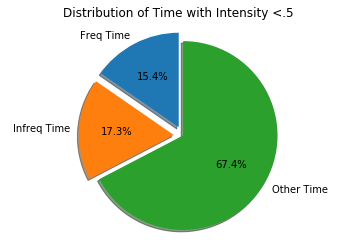

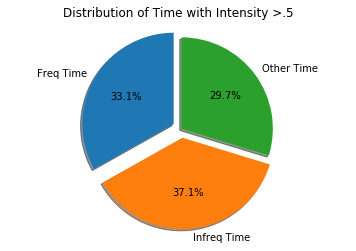

In [201]:

freq_time = [0,0]
infreq_time = [0,0]
other_time = [0,0]
for day in browser_days:
    if day[INTENSITY] <.5:
        freq_time[0] += math.exp(day[FREQ_TIME])
        infreq_time[0] += math.exp(day[INFREQ_TIME])
        other_time[0] += math.exp(day[OTHER_TIME])
    elif day[INTENSITY] > .5:
        freq_time[1] += math.exp(day[FREQ_TIME])
        infreq_time[1] += math.exp(day[INFREQ_TIME])
        other_time[1] += math.exp(day[OTHER_TIME])   
for i in range(0,2):
    pyplot.figure(765 + i)
    labels = 'Freq Time', 'Infreq Time', 'Other Time'
    sizes = [freq_time[i], infreq_time[i], other_time[i]]
    explode = (0.1, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    pyplot.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    pyplot.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    pyplot.title("Distribution of Time with Intensity " + ("<" if i == 0 else ">") + ".5")

0.009508037023301469


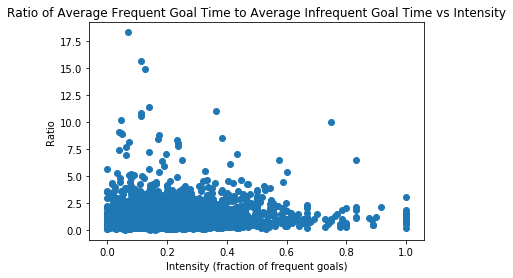

In [202]:
intensities = []
avg_freq_time = []
avg_infreq_time = []
ratio = []
from scipy import stats
for item in browser_days:
    if item[AVG_INFREQ_TIME] > 0 and item[AVG_FREQ_TIME] > 0:
        intensities.append(item[INTENSITY])
        avg_freq_time.append(item[AVG_FREQ_TIME])
        avg_infreq_time.append(item[AVG_INFREQ_TIME])
        ratio.append(item[AVG_FREQ_TIME]/item[AVG_INFREQ_TIME])
pyplot.figure(6246)
pyplot.title("Ratio of Average Frequent Goal Time to Average Infrequent Goal Time vs Intensity")
pyplot.xlabel("Intensity (fraction of frequent goals)")
pyplot.ylabel("Ratio")
pyplot.scatter(intensities, ratio)
slope, intercept, r_value, p_value, std_err = stats.linregress(intensities,ratio)
print(r_value)

<BarContainer object of 2 artists>

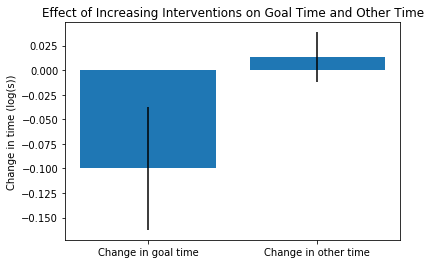

In [203]:
# Now let's try to generate that graph we made for Android -> change in time when goal changes frequency setting
user_goal_freq_avg = {}
for day in browser_days:
    user = day[HASH]
    if user not in user_goal_freq_avg:
        user_goal_freq_avg[user] = {}
    for goal_data in day[GOAL_TIMES]:
        if goal_data['goal'] != "www":
            if goal not in user_goal_freq_avg[user]:
                user_goal_freq_avg[user][goal] = {"time": {"frequent": [], "infrequent": []}, "other": {"frequent": [], "infrequent": []}}
            if (math.exp(day[TOTAL_TIME]) - math.exp(goal_data["time"])) > 0:
                user_goal_freq_avg[user][goal]["time"][goal_data["frequency"]].append(goal_data["time"])
                user_goal_freq_avg[user][goal]["other"][goal_data["frequency"]].append(math.log(math.exp(day[TOTAL_TIME]) - math.exp(goal_data["time"])))
change_in_goal_time = []
change_in_other_time = []
for user in user_goal_freq_avg:
    for goal in user_goal_freq_avg[user]:
        goal_data = user_goal_freq_avg[user][goal]
        if len(goal_data["time"]["frequent"]) > 0 and len(goal_data["time"]["infrequent"]) > 0:
            mean_freq_time = mean(goal_data["time"]["frequent"])
            mean_infreq_time = mean(goal_data["time"]["infrequent"])
            mean_freq_other = mean(goal_data["other"]["frequent"])
            mean_infreq_other = mean(goal_data["other"]["infrequent"])
            change_in_goal_time.append(mean_freq_time - mean_infreq_time)
            change_in_other_time.append(mean_freq_other - mean_infreq_other)
pyplot.title("Effect of Increasing Interventions on Goal Time and Other Time")
pyplot.ylabel("Change in time (log(s))")
pyplot.bar(["Change in goal time", "Change in other time"], [(mean(change_in_goal_time)), mean(change_in_other_time)] , .8, yerr=[sem(change_in_goal_time), sem(change_in_other_time)])
    

(array([1889., 1268.,  864.,  452.,  214.,  163.,   50.,   22.,   18.,
          57.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

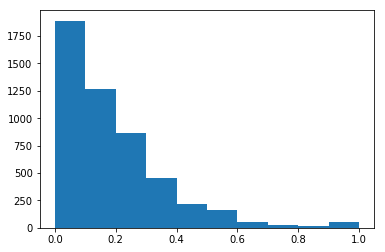

In [204]:
pyplot.figure(123)
pyplot.hist([day[INTENSITY] for day in browser_days])